In [12]:
import pandas as pd
import os
import tokenizers
import numpy as np
import torch
from scipy.special import softmax
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import seaborn as sns
os.listdir('../output/validation')

['cv.csv',
 'roberta-base-squad2_baseline_cv.csv',
 'bert_finetuned-squad_cv.csv',
 'bert_test_cv.csv',
 'roberta_base_squad2_pre_pro_cv.csv']

In [96]:
BERT_TOKENIZER = tokenizers.BertWordPieceTokenizer(
    "../input/vocab.txt",
    lowercase=True,
)
ROBERT_TOKENIZER = tokenizers.ByteLevelBPETokenizer(
    vocab_file="../input/roberta-base-squad2/vocab.json",
    merges_file="../input/roberta-base-squad2/merges.txt",
    lowercase=True,
    add_prefix_space=True
)
# Seq_tokenizer = SentencePieceTokenizer('../input/spiece.model')
#     TOKENIZER =  Seq_tokenizer  

In [97]:
SEED = 42
MAX_LEN = 95 
start_cols = [str(i) for i in range(MAX_LEN)]
end_cols = [str(i) for i in range(MAX_LEN, MAX_LEN*2)]

In [117]:
DATA_PATH = '../model/0614_1/cv.csv'
#DATA_PATH = '../model/GCNN/cv.csv'

In [118]:
pred_df = pd.read_csv(DATA_PATH)
pred_df.keys()

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
       ...
       '180', '181', '182', '183', '184', '185', '186', '187', '188', '189'],
      dtype='object', length=190)

In [119]:
trn_df = pd.read_csv('../input/train.csv')
df = trn_df.dropna()
#index = trn_df[trn_df.sentiment != 'neutral'].index.values

df['text'] = df['text'].astype(str)
df['selected_text'] = df['selected_text'].astype(str)
pred_df = pd.read_csv(DATA_PATH)
# trn_df = trn_df.iloc[index]
# pred_df = pred_df.iloc[index]
assert len(df) == len(pred_df)

df = pd.concat([df, pred_df], axis=1)
df = df.dropna()

# df['start_idx'] = np.argmax(df[start_cols].values, axis=1)
# df['end_idx'] = np.argmax(df[end_cols].values, axis=1)

# df['text_len'] = df['text'].apply(lambda x : len(x.split()))
# df['selected_text'] = df['selected_text'].astype(str)
# df['selected_text_len'] = df['selected_text'].apply(lambda x : len(x.split()))
# df['selected_rate'] = df['selected_text_len'] / df['text_len']

In [120]:
def cal_jaccard(fin_output_start, fin_output_end, fin_offset, fin_orig_sentiment, fin_orig_selected, fin_orig_text, rm_length):

    for i in range(fin_output_start.shape[0]):
        output_start = fin_output_start[i]
        output_start = np.argmax(output_start)
        output_end = fin_output_end[i]
        output_end = np.argmax(output_end)
        offset = fin_offset[i]
        orig_sentiment = fin_orig_sentiment[i]
        orig_selected = fin_orig_selected[i]
        orig_text = fin_orig_text[i]
    
        if output_start > output_end:
            output_end = output_start
        
        output_string = ""
        for j in range(output_start, output_end+1):
            output_string += orig_text[offset[j][0]:offset[j][1]]
            if (j+1) < len(offset) and offset[j][1] < offset[j+1][0]:
                output_string += " "
        
        #output_string = post_process(output_string)
        output_string = output_string.strip()
        if orig_sentiment == 'neutral' or len(orig_text.split()) < rm_length:
            output_string = orig_text
            neu_score.append(jaccard(output_string, orig_selected))

        elif orig_sentiment == 'positive':
            pos_score.append(jaccard(output_string, orig_selected))

        else:
            neg_score.append(jaccard(output_string, orig_selected))
 

In [121]:
def encode(text, tokenizer, sentiment, output_start, output_end):
    text = " ".join(str(text).split())

    token_out = tokenizer.encode(text)
    offsets = token_out.offsets
    ids = token_out.ids
    
    offsets = [(0,0)] * 4 + offsets + [(0,0)]
    if len(offsets) < MAX_LEN:
        padding_len = MAX_LEN - len(offsets)
        offsets = offsets + [(0,0)] * padding_len

    if output_start > output_end:
        output_end = output_start
    
    output_string = ''
    for j in range(output_start, output_end+1):
        output_string += text[offsets[j][0]:offsets[j][1]] 
        if (j+1) < len(offsets) and offsets[j][1] < offsets[j+1][0]:
                output_string += " "
    output_string = output_string.strip()
    #output_string = tokenizer.decode(ids[output_start-4:output_end+1-4]).lower().strip()
#     if not output_string.lower().strip() == tokenizer.decode(ids[output_start-4:output_end+1-4]).lower().strip():
#         print(output_string.strip())
#         print(tokenizer.decode(ids[output_start-4:output_end+1-4]).strip())
#         print('------')
    
    if sentiment == 'neutral' or len(text.split()) < 4:
        output_string = text

    return output_string.strip()

In [122]:
def jaccard(str1, str2): 
    a = set(str1.lower().split()) 
    b = set(str2.lower().split())
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))

def filt_thresh(idx, thresh=0):
    idx = idx[idx > thresh]
    
    return np.nonzero(idx)[0] if len(np.nonzero(idx)[0]) > 0 else np.array([0])

In [123]:
outputs = []
score = []

for row in df.itertuples():
    text = row[2]
    selected_text = row[3]
    sentiment = row[4]
    start_idx = np.array(row[5:5+MAX_LEN])
    end_idx = np.array(row[5+MAX_LEN:5+MAX_LEN*2])
        
    start_idx = np.argmax(start_idx)
    end_idx = np.argmax(end_idx)

    output_string = encode(text, ROBERT_TOKENIZER, sentiment, start_idx, end_idx)
    outputs.append(output_string)
    score.append(jaccard(selected_text, output_string))

print(sum(score)/len(score))

0.5271167349572926


In [105]:
df['pred'] = outputs
df['jaccard'] = score

In [13]:
neural_df = df.loc[df['sentiment'] == 'neutral']
pos_df = df.loc[df['sentiment'] == 'positive']
neg_df = df.loc[df['sentiment'] == 'negative']

# Dive deep neutral

In [10]:
def thresh(jaccard, df):
    for i, row in df.iterrows():
        if row['jaccard'] < jaccard:
            print(f'Index : {i}')
            print('text : ', row['text'])
            print('selected_text : ', row['selected_text'])
            print('pred : ', row['pred'])
            print('sentiment : ', row['sentiment'])
            print('jaccard : ', row['jaccard'])
            print('start index : ', np.argmax(np.array(row[[str(i) for i in range(128)]])))
            print('end index : ', np.argmax(np.array(row[[str(i) for i in range(128,256)]])))
            print('--------------------')

In [11]:
thresh(0.8, neural_df)

Index : 35
text :  Thats it, its the end. Tears for Fears vs Eric Prydz, DJ Hero   http://bit.ly/2Hpbg4
selected_text :  Thats it, its the end. Tears for Fears
pred :  Thats it, its the end. Tears for Fears vs Eric Prydz, DJ Hero http://bit.ly/2Hpbg4
sentiment :  neutral
jaccard :  0.5714285714285714
start index :  4
end index :  9
--------------------
Index : 186
text :  _420 why baby?
selected_text :  why baby?
pred :  _420 why baby?
sentiment :  neutral
jaccard :  0.6666666666666666
start index :  6
end index :  7
--------------------
Index : 198
text :  Had nicotine replacement patch on for 4 hours. So far, so good, but I did sleep for most of those 4 hours. Getting a bit twitchy now
selected_text :  So far, so good, but I did sleep for most of those 4 hours. Getting a bit twitchy now
pred :  Had nicotine replacement patch on for 4 hours. So far, so good, but I did sleep for most of those 4 hours. Getting a bit twitchy now
sentiment :  neutral
jaccard :  0.782608695652174
start ind

Index : 2272
text :  #twpp ..still nw in trending topics..
selected_text :  still nw in trending topics..
pred :  #twpp ..still nw in trending topics..
sentiment :  neutral
jaccard :  0.5714285714285714
start index :  4
end index :  14
--------------------
Index : 2345
text :  Early morning R&B.  ? http://blip.fm/~5jimj
selected_text :  Early morning R&B.
pred :  Early morning R&B. ? http://blip.fm/~5jimj
sentiment :  neutral
jaccard :  0.6
start index :  4
end index :  10
--------------------
Index : 2384
text :  Must be time of month: Watering eyes AGAIN!: http://tinyurl.com/cuwj2b (speciaal voor : zo vind ik ze wï¿½l leuk!  )
selected_text :  st be time of month: Watering eyes AGAIN!:
pred :  Must be time of month: Watering eyes AGAIN!: http://tinyurl.com/cuwj2b (speciaal voor : zo vind ik ze wï¿½l leuk! )
sentiment :  neutral
jaccard :  0.35
start index :  10
end index :  34
--------------------
Index : 2385
text :  _x butbutbuttt he replied to you loads
selected_text :  he replied

selected_text :  argh. Interested.
pred :  argh. Interested. Time maybe can`t go. Maybe.
sentiment :  neutral
jaccard :  0.2857142857142857
start index :  4
end index :  7
--------------------
Index : 4654
text :  ???ï¿½ï¿½  ???CE d grade?mock?????, ???????
selected_text :  ?CE d grade?mock?
pred :  ???ï¿½ï¿½ ???CE d grade?mock?????, ???????
sentiment :  neutral
jaccard :  0.14285714285714285
start index :  13
end index :  20
--------------------
Index : 4683
text :  Sorry if I`m unsociable I`m loading up stock in the shop, mums making me
selected_text :  Sorry if I`m unsociable I`
pred :  Sorry if I`m unsociable I`m loading up stock in the shop, mums making me
sentiment :  neutral
jaccard :  0.2857142857142857
start index :  4
end index :  4
--------------------
Index : 4799
text :   that gets around the problem I had of doing it all myself  good idea.
selected_text :  d the problem I had of doing it all myself  good idea.
pred :  that gets around the problem I had of doing it all mys

end index :  17
--------------------
Index : 6420
text :  http://twitpic.com/4jb0q - And a few more
selected_text :  And a few more
pred :  http://twitpic.com/4jb0q - And a few more
sentiment :  neutral
jaccard :  0.6666666666666666
start index :  18
end index :  21
--------------------
Index : 6486
text :  _PaulEvans heyyyyy boo
selected_text :  heyyyyy boo
pred :  _PaulEvans heyyyyy boo
sentiment :  neutral
jaccard :  0.6666666666666666
start index :  9
end index :  12
--------------------
Index : 6692
text :  there are # days of summervac & school comes along just 2 end it & the annual problem of r generation is finding a good way 2 spend it!!
selected_text :  the annual problem of r generation is finding a good way 2 spend it!!
pred :  there are # days of summervac & school comes along just 2 end it & the annual problem of r generation is finding a good way 2 spend it!!
sentiment :  neutral
jaccard :  0.5384615384615384
start index :  30
end index :  30
--------------------
Index :

Index : 8807
text :  ? today  and tomorrow at  taipei, anyone  free for drink?  http://plurk.com/p/rpgyy
selected_text :  today  and tomorrow at  taipei, anyone  free for drink
pred :  ? today and tomorrow at taipei, anyone free for drink? http://plurk.com/p/rpgyy
sentiment :  neutral
jaccard :  0.6666666666666666
start index :  13
end index :  16
--------------------
Index : 8810
text :  Part of my Neuroanatomy take-home test.  After this, Iï¿½m... http://tinyurl.com/de8y47
selected_text :  Part of my Neuroanatomy take-home test.
pred :  Part of my Neuroanatomy take-home test. After this, Iï¿½m... http://tinyurl.com/de8y47
sentiment :  neutral
jaccard :  0.6
start index :  16
end index :  25
--------------------
Index : 8862
text :   Hey Ruthie girl... u send me all these lovely twitts but never respond!  I`m hurt... how`s Mikey and Dion?
selected_text :  these lovely twitts but never respond!  I`m hurt...
pred :  Hey Ruthie girl... u send me all these lovely twitts but never respond!

Index : 10946
text :  Happy Star Wars Day? OHHHH...now I get it. May the 4th be with you.  love it. (and mondays). (sorry again) #starwarsday
selected_text :  love it. (and mondays). (sorry again)
pred :  Happy Star Wars Day? OHHHH...now I get it. May the 4th be with you. love it. (and mondays). (sorry again) #starwarsday
sentiment :  neutral
jaccard :  0.3
start index :  4
end index :  26
--------------------
Index : 10960
text :   is a lumberjack  http://twitpic.com/4wqe8
selected_text :  is a lumberjack
pred :  is a lumberjack http://twitpic.com/4wqe8
sentiment :  neutral
jaccard :  0.75
start index :  6
end index :  7
--------------------
Index : 10985
text :  Bran!! Watch my video!!!!! please dont make me go stalker status 2nite  http://bit.ly/3Ysav
selected_text :  Bran!! Watch my video!!!!! please dont make me go stalker status 2n
pred :  Bran!! Watch my video!!!!! please dont make me go stalker status 2nite http://bit.ly/3Ysav
sentiment :  neutral
jaccard :  0.7857142857142857


Index : 14041
text :   hahah I wish that was true. This is really really bad  just gonna stay home and chill tonight. And as usual I REALLY wanted to go.
selected_text :  hahah I wish that was true. This is really really bad  just gonna stay home and chill tonight.
pred :  hahah I wish that was true. This is really really bad just gonna stay home and chill tonight. And as usual I REALLY wanted to go.
sentiment :  neutral
jaccard :  0.7727272727272727
start index :  13
end index :  17
--------------------
Index : 14072
text :  I wish I could go to E3.  Oh well....
selected_text :  I wish I could go to E3.  Oh well...
pred :  I wish I could go to E3. Oh well....
sentiment :  neutral
jaccard :  0.7777777777777778
start index :  4
end index :  5
--------------------
Index : 14126
text :  Exhausted. Thank goodness my race is almost here! All this training is ruining my social life
selected_text :  Exhausted. Thank goodness
pred :  Exhausted. Thank goodness my race is almost here! All this t

Index : 16216
text :  Hey cool: http://oproer.com/twwwitter/
selected_text :  Hey cool:
pred :  Hey cool: http://oproer.com/twwwitter/
sentiment :  neutral
jaccard :  0.6666666666666666
start index :  4
end index :  5
--------------------
Index : 16258
text :   My pleasure and sorry to hear about the pollen thing
selected_text :  My pleasure and sorry
pred :  My pleasure and sorry to hear about the pollen thing
sentiment :  neutral
jaccard :  0.4
start index :  4
end index :  5
--------------------
Index : 16324
text :   still got one more year with t-mo tho  I might just get a new bb curve. Not too concerned abt apps. Batt life is important
selected_text :  . Not too concerned abt apps. Batt life is important
pred :  still got one more year with t-mo tho I might just get a new bb curve. Not too concerned abt apps. Batt life is important
sentiment :  neutral
jaccard :  0.34615384615384615
start index :  24
end index :  34
--------------------
Index : 16331
text :  _gurl_cece what up?
s

start index :  4
end index :  4
--------------------
Index : 18217
text :  _argie Yes I am
selected_text :  Yes I am
pred :  _argie Yes I am
sentiment :  neutral
jaccard :  0.75
start index :  7
end index :  9
--------------------
Index : 18239
text :  I`m still thinking ... Idk
selected_text :  I`m still thinking
pred :  I`m still thinking ... Idk
sentiment :  neutral
jaccard :  0.6
start index :  4
end index :  11
--------------------
Index : 18541
text :   Doing okay. How are you doing?
selected_text :  Doing okay.
pred :  Doing okay. How are you doing?
sentiment :  neutral
jaccard :  0.3333333333333333
start index :  4
end index :  5
--------------------
Index : 18615
text :  last #ff  _Diesel    _Web_Design     
selected_text :  last #ff  _Diesel    _Web_Desig
pred :  last #ff _Diesel _Web_Design
sentiment :  neutral
jaccard :  0.6
start index :  4
end index :  6
--------------------
Index : 18680
text :   ditching out again?  you will be missed. I wish my ruby boys would represen

start index :  4
end index :  7
--------------------
Index : 21071
text :  Sunday sunshine track  ? http://blip.fm/~5z7cg
selected_text :  Sunday sunshine track
pred :  Sunday sunshine track ? http://blip.fm/~5z7cg
sentiment :  neutral
jaccard :  0.6
start index :  4
end index :  6
--------------------
Index : 21231
text :  some1 said if your not online your a no1...if you are online your a no1.. can`t bloody win  lol
selected_text :  can`t bloody win  lol
pred :  some1 said if your not online your a no1...if you are online your a no1.. can`t bloody win lol
sentiment :  neutral
jaccard :  0.26666666666666666
start index :  25
end index :  30
--------------------
Index : 21300
text :  ... Money money money...      http://twitpic.com/664uz
selected_text :  ... Money money money...      http://twitpic.com/664
pred :  ... Money money money... http://twitpic.com/664uz
sentiment :  neutral
jaccard :  0.6
start index :  5
end index :  8
--------------------
Index : 21348
text :  @_writersbloc

Index : 22709
text :  http://twitpic.com/4w269 - My 789 pacman pic
selected_text :  My 789 pacman pic
pred :  http://twitpic.com/4w269 - My 789 pacman pic
sentiment :  neutral
jaccard :  0.6666666666666666
start index :  16
end index :  21
--------------------
Index : 22762
text :  i want candy!!!
selected_text :  i want candy!!
pred :  i want candy!!!
sentiment :  neutral
jaccard :  0.5
start index :  4
end index :  7
--------------------
Index : 22814
text :  I am the queen of losing things. Important things like keycards and bus passes.
selected_text :  losing
pred :  I am the queen of losing things. Important things like keycards and bus passes.
sentiment :  neutral
jaccard :  0.07142857142857142
start index :  4
end index :  10
--------------------
Index : 22874
text :   yes the new one, I adore both though  who doesn`t love Vincent!!!
selected_text :  I adore both though  who doesn`t love Vincent!!!
pred :  yes the new one, I adore both though who doesn`t love Vincent!!!
sentimen

Index : 24573
text :  _and_Easy when will these stores in Sacramento open? Been waiting and nothing
selected_text :  Been waiting and nothing
pred :  _and_Easy when will these stores in Sacramento open? Been waiting and nothing
sentiment :  neutral
jaccard :  0.3333333333333333
start index :  17
end index :  20
--------------------
Index : 24619
text :  Was about to head downtown...now there`s a flash flood!  - Photo: http://bkite.com/07XFs
selected_text :  Was about to head downtown...now there`s a flash flood!
pred :  Was about to head downtown...now there`s a flash flood! - Photo: http://bkite.com/07XFs
sentiment :  neutral
jaccard :  0.75
start index :  15
end index :  16
--------------------
Index : 24650
text :  _UK That sucks! I had my exams be4 half term so It`s all good. Although they were major subjects now I have languages and stuff
selected_text :  That sucks! I had my exams be4 half term so It`s all good.
pred :  _UK That sucks! I had my exams be4 half term so It`s all goo

end index :  34
--------------------
Index : 26083
text :  Hey  'keep clear'   (robluketic live > http://ustre.am/2w5v)
selected_text :  Hey  'keep clear'
pred :  Hey 'keep clear' (robluketic live > http://ustre.am/2w5v)
sentiment :  neutral
jaccard :  0.42857142857142855
start index :  4
end index :  7
--------------------
Index : 26111
text :  OMG that little girl on BGT!!!!!!!!
selected_text :  OMG that little girl on BGT!!
pred :  OMG that little girl on BGT!!!!!!!!
sentiment :  neutral
jaccard :  0.7142857142857143
start index :  4
end index :  5
--------------------
Index : 26153
text :  Going Outro... Peace.
selected_text :  Peace.
pred :  Going Outro... Peace.
sentiment :  neutral
jaccard :  0.3333333333333333
start index :  8
end index :  8
--------------------
Index : 26166
text :   i knew that, jus givin u a hard time hehe
selected_text :  u a hard time hehe
pred :  i knew that, jus givin u a hard time hehe
sentiment :  neutral
jaccard :  0.5
start index :  15
end index :  1

In [12]:
thresh(0.8, pos_df)

Index : 6
text :  2am feedings for the baby are fun when he is all smiles and coos
selected_text :  fun
pred :  are fun
sentiment :  positive
jaccard :  0.5
start index :  11
end index :  12
--------------------
Index : 9
text :   Journey!? Wow... u just became cooler.  hehe... (is that possible!?)
selected_text :  Wow... u just became cooler.
pred :  wow... u just became cooler
sentiment :  positive
jaccard :  0.6666666666666666
start index :  6
end index :  11
--------------------
Index : 11
text :  I really really like the song Love Story by Taylor Swift
selected_text :  like
pred :  i really really like
sentiment :  positive
jaccard :  0.3333333333333333
start index :  4
end index :  7
--------------------
Index : 21
text :  Playing Ghost Online is really interesting. The new updates are Kirin pet and Metamorph for third job.  Can`t wait to have a dragon pet
selected_text :  interesting.
pred :  interesting
sentiment :  positive
jaccard :  0.0
start index :  9
end index :  9
------

end index :  11
--------------------
Index : 265
text :  FTSK and Mercy Mercedes were amazing tonight.. as always
selected_text :  were amazing tonight..
pred :  amazing
sentiment :  positive
jaccard :  0.3333333333333333
start index :  12
end index :  12
--------------------
Index : 266
text :    hope he is ok!
selected_text :  hope
pred :  hope he is ok
sentiment :  positive
jaccard :  0.25
start index :  4
end index :  7
--------------------
Index : 267
text :  can`t school just be done already? it hurts too much... seeing him every day
selected_text :  it hurts too much...
pred :  seeing him every day
sentiment :  positive
jaccard :  0.0
start index :  18
end index :  21
--------------------
Index : 273
text :  Went to a party last night. Dindin and I showed up in matching outfits ) GREAT MINDS THINK ALIKE ) Anyway, happy birthday, ate lara
selected_text :  GREAT
pred :  great minds think alike ) anyway, happy
sentiment :  positive
jaccard :  0.14285714285714285
start index :  22
e

Index : 513
text :  _Libertine um, glad you enjoyed it...
selected_text :  glad
pred :  glad you enjoyed it...
sentiment :  positive
jaccard :  0.25
start index :  10
end index :  14
--------------------
Index : 518
text :   sounds like you all had a great night . i`m glad it was successful
selected_text :  i`m glad
pred :  sounds like you all had a great night . i`m glad it was successful
sentiment :  positive
jaccard :  0.14285714285714285
start index :  4
end index :  19
--------------------
Index : 521
text :  Garden going well, almost all the corn and peas are up, no onions or beets up yet though.
selected_text :  well,
pred :  garden going well
sentiment :  positive
jaccard :  0.0
start index :  4
end index :  6
--------------------
Index : 523
text :  Ahhh i`m sqeaky clean and fresh. Even though i`m wearing dirty clothes  I love Two and a Half Men - it`s amazing!
selected_text :  Ahhh i`m sqeaky clean and fresh. Even though i`m wearing dirty clothes  I love Two and a Half Men - 

end index :  19
--------------------
Index : 766
text :  Jon made one of the greatest dinners ever: roast pork tenderloin on a bed of wild rice on a bed of mixed greens & yummy sauce. No wine
selected_text :  one of the greatest dinners ever:
pred :  y
sentiment :  positive
jaccard :  0.0
start index :  32
end index :  12
--------------------
Index : 768
text :  Shower. Class. More class. Taking care of my lady-friend. Writing like there`s no tomorrow.
selected_text :  Shower. Class. More class. Taking care of my lady-friend.
pred :  taking care of my lady-friend. writing like there`s no tomorrow
sentiment :  positive
jaccard :  0.38461538461538464
start index :  11
end index :  25
--------------------
Index : 769
text :  Rockstar photographer shoot went great tonight. A little different than the usual stuff - very nice.
selected_text :  great
pred :  very nice
sentiment :  positive
jaccard :  0.0
start index :  20
end index :  21
--------------------
Index : 770
text :   great pics! Y

end index :  19
--------------------
Index : 1003
text :  can`t believe I just drove all the way back to school...whatever HAPPY MOTHER`S DAY: Mommy, Precious, Candis and Granny
selected_text :  HAPPY
pred :  happy mother`s day
sentiment :  positive
jaccard :  0.3333333333333333
start index :  19
end index :  23
--------------------
Index : 1008
text :   That`s me on a good day
selected_text :  That`s me on a good day
pred :  good day
sentiment :  positive
jaccard :  0.3333333333333333
start index :  10
end index :  11
--------------------
Index : 1010
text :   I created my account just to get a chance to chat with you (: I ADMIRE YOU! you`re amazing! you inspire me to write  <3
selected_text :  : I ADMIRE YOU! you`re amazing! you inspire me to write  <3
pred :  i admire you! you`re amazing
sentiment :  positive
jaccard :  0.3076923076923077
start index :  19
end index :  26
--------------------
Index : 1011
text :  Think I`ll go enjoy the sun`s rays again...I LOVE being off work
selec

--------------------
Index : 1261
text :  what a beautiful morning! nice to be out
selected_text :  what a beautiful morning!
pred :  beautiful
sentiment :  positive
jaccard :  0.25
start index :  6
end index :  6
--------------------
Index : 1263
text :  _ray Bright Eyes=Contentment
selected_text :  Contentment
pred :  =contentment
sentiment :  positive
jaccard :  0.0
start index :  8
end index :  10
--------------------
Index : 1276
text :   http://twitpic.com/4vuuy - thats the most colorful thing ive seen all day,wow.
selected_text :  thats the most colorful thing ive seen all day,wow.
pred :  ,wow
sentiment :  positive
jaccard :  0.0
start index :  26
end index :  27
--------------------
Index : 1279
text :   I just started watching 30 Rock too, borrowed seasons 1 and 2 from my dad   so good.
selected_text :  so goo
pred :  so good
sentiment :  positive
jaccard :  0.3333333333333333
start index :  20
end index :  21
--------------------
Index : 1280
text :   i like OGBERRY
selected

end index :  22
--------------------
Index : 1547
text :   had  a little family party tonight   hope it rocked
selected_text :  t   hope it rock
pred :  hope it rocked
sentiment :  positive
jaccard :  0.4
start index :  10
end index :  12
--------------------
Index : 1550
text :   WHOO HOO. Congrats on getting under 200lbs
selected_text :  WHOO HOO. Congrats on getting under 200lbs
pred :  congrats
sentiment :  positive
jaccard :  0.14285714285714285
start index :  9
end index :  10
--------------------
Index : 1555
text :   I`d love that. And, don`t think of it as easy. Think of it as enthusiastic.
selected_text :  Think of it as enthusiastic.
pred :  i`d love
sentiment :  positive
jaccard :  0.0
start index :  4
end index :  7
--------------------
Index : 1562
text :  Fighting with Nagios configuration.  Great tool but the config is a bit of a labour
selected_text :  Great tool
pred :  great
sentiment :  positive
jaccard :  0.5
start index :  11
end index :  11
--------------------
I

start index :  4
end index :  6
--------------------
Index : 1794
text :  omds! holly steel, bless her!  x
selected_text :  bless her!
pred :  bless her
sentiment :  positive
jaccard :  0.3333333333333333
start index :  12
end index :  13
--------------------
Index : 1795
text :  Somebody please save the polar bears!
selected_text :  Somebody please save the polar bears!
pred :  somebody please save
sentiment :  positive
jaccard :  0.5
start index :  4
end index :  6
--------------------
Index : 1797
text :  I don`t feel any pressure right now...    Happy Mother`s Day people...
selected_text :  Happ
pred :  happy
sentiment :  positive
jaccard :  0.0
start index :  14
end index :  14
--------------------
Index : 1802
text :  New day in new home   happy mom day 2 me!
selected_text :  happy mom day 2 me!
pred :  happy
sentiment :  positive
jaccard :  0.2
start index :  9
end index :  9
--------------------
Index : 1803
text :  my momma is comin 2night !  2morrow tennis day with p?nar yupp

start index :  4
end index :  9
--------------------
Index : 2022
text :   ah its getting there  still a fair bit to go, but it`s coming together fairly well! aw  where are you from?
selected_text :  er fairly well!
pred :  fairly well
sentiment :  positive
jaccard :  0.25
start index :  21
end index :  22
--------------------
Index : 2024
text :  Lol @ me and  whispering so we don`t get in trouble and being almost 30! Feels great to be home feeling like kids
selected_text :  Lol @ me and  whispering so we don`t get in trouble and being almost 30! Feels great to be home feeling like kids
pred :  feels great
sentiment :  positive
jaccard :  0.09090909090909091
start index :  22
end index :  23
--------------------
Index : 2025
text :   http://twitpic.com/4jcf1 - Looks great!  Love the way they did the bottom.
selected_text :  great!
pred :  looks great
sentiment :  positive
jaccard :  0.0
start index :  17
end index :  18
--------------------
Index : 2028
text :   I know, thx  But I`ll 

start index :  4
end index :  9
--------------------
Index : 2309
text :  Today is my first Mothers Day with my little boy. Hope you`re having a beautiful Mothers Day too
selected_text :  Today is my first Mothers Day with my little boy. Hope you`re having a beautiful Mothers Day too
pred :  beautiful
sentiment :  positive
jaccard :  0.06666666666666667
start index :  21
end index :  21
--------------------
Index : 2312
text :  Happy morning Sunshine  It`s May 4! I`m driving with the windows down and singing and smiling and not wearing shoes because i`m Kirsten!
selected_text :  Happy morning Sunshine
pred :  happy
sentiment :  positive
jaccard :  0.3333333333333333
start index :  4
end index :  4
--------------------
Index : 2316
text :   Wow! Some person u are!
selected_text :  Wow!
pred :  wow
sentiment :  positive
jaccard :  0.0
start index :  4
end index :  4
--------------------
Index : 2325
text :  Lebron maybe the MVP this year ... but I like the Lakers to win the NBA Title
sel

start index :  4
end index :  18
--------------------
Index : 2571
text :   Happy Birthday! I hope you are doing well and had a great Birthday day
selected_text :  great
pred :  happy birthday! i hope you are doing well and had a great birthday day
sentiment :  positive
jaccard :  0.07142857142857142
start index :  4
end index :  18
--------------------
Index : 2573
text :   aww  but typing from beyond the grave...impressive
selected_text :  ..impressive
pred :  ...impressive
sentiment :  positive
jaccard :  0.0
start index :  12
end index :  14
--------------------
Index : 2575
text :    caught me at lunch today... you were correct of he stalking me
selected_text :  . you were correct
pred :  you were correct
sentiment :  positive
jaccard :  0.75
start index :  10
end index :  12
--------------------
Index : 2576
text :  http://twitpic.com/67fcj - what i have to resort to wearing today cause i haven`t finished my laundry. lol.
selected_text :  my laundry. lol.
pred :  lol
sentiment : 

end index :  7
--------------------
Index : 2816
text :  Lil cuz coming round today she 5  aww  haha
selected_text :  haha
pred :  aww haha
sentiment :  positive
jaccard :  0.5
start index :  12
end index :  14
--------------------
Index : 2820
text :  Goodmorning twitter bugs.. happy monday to you all! Today marks my first official day at my first fulltime job.. time to get ready!
selected_text :  happy
pred :  goodmorning twitter bugs.. happy monday to you all
sentiment :  positive
jaccard :  0.125
start index :  4
end index :  14
--------------------
Index : 2840
text :   Good Luck
selected_text :  Good
pred :  Good Luck
sentiment :  positive
jaccard :  0.5
start index :  4
end index :  5
--------------------
Index : 2845
text :  Apple is expected to launch a new iPhone this summer.  Hi my name is Judy and I am addicted to Apple products.
selected_text :  expected
pred :  i am addicted to apple products
sentiment :  positive
jaccard :  0.0
start index :  24
end index :  29
---------

Index : 3120
text :  just tried talking........voice died before end of sentence! Annpyimg thing id, i feel fine!! Another day of not playing the hits
selected_text :  i feel fine!! An
pred :  i feel fine
sentiment :  positive
jaccard :  0.4
start index :  21
end index :  23
--------------------
Index : 3123
text :   http://twitpic.com/4jam0 - better lighting would have enhanced the photo... nice angle though...
selected_text :  nice angle though...
pred :  nice
sentiment :  positive
jaccard :  0.3333333333333333
start index :  24
end index :  24
--------------------
Index : 3124
text :  May the 4th be with you. Happy Star Wars Day!  http://ow.ly/52Aw
selected_text :  Happy Star Wars
pred :  happy
sentiment :  positive
jaccard :  0.3333333333333333
start index :  12
end index :  12
--------------------
Index : 3126
text :   Oh, I see. Daily life shots? It`ll be interesting as well.
selected_text :  interesting
pred :  it`ll be interesting
sentiment :  positive
jaccard :  0.333333333333

end index :  9
--------------------
Index : 3394
text :  Dlukasrossi Lukas- your amazing wife, her updates are locked! Hard to convince people to follow protected profiles,
selected_text :  amazing
pred :  your amazing
sentiment :  positive
jaccard :  0.5
start index :  13
end index :  14
--------------------
Index : 3399
text :    Wow.  I hope he gets better... cancer can GTFO.
selected_text :  Wow.  I hope he gets bette
pred :  wow. i hope he gets better...
sentiment :  positive
jaccard :  0.7142857142857143
start index :  4
end index :  11
--------------------
Index : 3400
text :  get down tonight: http://bit.ly/QxXhi  the bridesmaids, moms, bride & I rockin` the reception
selected_text :  moms, bride & I rockin` the reception
pred :  i rockin` the reception
sentiment :  positive
jaccard :  0.5714285714285714
start index :  27
end index :  32
--------------------
Index : 3402
text :  Eating Which Wich, yumm! Dont think I`ve had it since the season ended
selected_text :  yumm!
pred :

end index :  4
--------------------
Index : 3632
text :   haha well, kinda! I`m Mommy to my lil` pom-chi  hehe  thank you! ;)
selected_text :  haha well, kinda! I`m Mommy to my lil` pom-chi  hehe  thank you!
pred :  thank you
sentiment :  positive
jaccard :  0.07692307692307693
start index :  24
end index :  25
--------------------
Index : 3634
text :   Cool, I used to live 5 houses to the left of that place  Always something going on :p
selected_text :  Cool,
pred :  cool
sentiment :  positive
jaccard :  0.0
start index :  4
end index :  4
--------------------
Index : 3640
text :  Going to bed. Talk to ya later!  goodnight birdies LOL
selected_text :  goodnight birdies LOL
pred :  goodnight
sentiment :  positive
jaccard :  0.3333333333333333
start index :  13
end index :  14
--------------------
Index : 3641
text :  Just came back from hanging out with some friends + cocktails. <3 I`m not drunk, but feeling good.  Hope everyone`s well?
selected_text :  good.
pred :  feeling good
senti

end index :  10
--------------------
Index : 3852
text :   Have you met me? (lol) MY MIDDLE NAME IS CREEPY FGS
selected_text :  (lol)
pred :  creepy fgs
sentiment :  positive
jaccard :  0.0
start index :  16
end index :  18
--------------------
Index : 3853
text :   hahah  i loveeee him though.
selected_text :  i loveeee him
pred :  loveeee him though
sentiment :  positive
jaccard :  0.5
start index :  8
end index :  12
--------------------
Index : 3858
text :  Happy Mother`s Day to all my favorite moms.
selected_text :  Happy
pred :  happy mother`s day to all my favorite moms
sentiment :  positive
jaccard :  0.125
start index :  4
end index :  13
--------------------
Index : 3865
text :  It`s a really warm day in Seattle! My reeses chocolate is melting!!!
selected_text :  It`s a really warm day in Seattle!
pred :  it`s a really warm day in seattle! my reeses chocolate is melting!!!
sentiment :  positive
jaccard :  0.5833333333333334
start index :  4
end index :  22
-------------------

end index :  21
--------------------
Index : 4106
text :   Thank a Chu?t ï¿½  Ch?c v?y quï¿½, hik, ch?c em ph?i ?i h?c 1 khï¿½a ph? c?p ki?n th?c c? khï¿½ g?p =.=
selected_text :  Thank a Chu?
pred :  thank
sentiment :  positive
jaccard :  0.3333333333333333
start index :  4
end index :  4
--------------------
Index : 4107
text :   hmmm Essense awards would be fun... but also pricy
selected_text :  fun.
pred :  fun
sentiment :  positive
jaccard :  0.0
start index :  11
end index :  11
--------------------
Index : 4120
text :  wish it wasn`t raining
selected_text :  wish
pred :  wish it wasn`t raining
sentiment :  positive
jaccard :  0.25
start index :  4
end index :  9
--------------------
Index : 4124
text :  I love that Joan Rivers says it`s Family First.
selected_text :  I love that Joan Rivers says it`s Family First.
pred :  i love
sentiment :  positive
jaccard :  0.2222222222222222
start index :  4
end index :  5
--------------------
Index : 4125
text :  Happy mother`s day to all 

end index :  25
--------------------
Index : 4336
text :  happiest girl in the world.  best weekend ever and I can`t wait for next weekend either!!!  so grateful for all my blessings!
selected_text :  happiest
pred :  happiest girl in the world. best weekend ever and i can`t wait for next weekend either!!! so grateful for all my blessings
sentiment :  positive
jaccard :  0.05
start index :  4
end index :  29
--------------------
Index : 4339
text :  watching because i said so! happy mothers day!
selected_text :  watching because i said so! happy mothers day!
pred :  happy
sentiment :  positive
jaccard :  0.125
start index :  10
end index :  10
--------------------
Index : 4343
text :     good point!! Mine is on its way. How did he get delivered?  I will post pics too wen I get him
selected_text :  goo
pred :  good
sentiment :  positive
jaccard :  0.0
start index :  4
end index :  4
--------------------
Index : 4347
text :   i KNOW! AHH!  so fun!
selected_text :  so fun!
pred :  so fun


start index :  22
end index :  31
--------------------
Index : 4574
text :   Oh! Don`t you just love these Vodafone series of Ads ... The best picturisation ever
selected_text :  e best picturisation ever
pred :  best
sentiment :  positive
jaccard :  0.25
start index :  22
end index :  22
--------------------
Index : 4575
text :  Listening to the simply awesome Ratatat on a bank holiday monday before a BBQ later  http://bit.ly/gJqSh
selected_text :  simply awesome Ra
pred :  awesome
sentiment :  positive
jaccard :  0.3333333333333333
start index :  8
end index :  8
--------------------
Index : 4581
text :   dude, I can safely say I was blown away when I heard Attics. I`ll make sure I pass it on as much as I can!
selected_text :  dude, I can safely say I was blown away when I heard Attics.
pred :  blown away
sentiment :  positive
jaccard :  0.18181818181818182
start index :  12
end index :  13
--------------------
Index : 4594
text :   Goodmorning to you!Thank you so much for being so k

start index :  10
end index :  11
--------------------
Index : 4794
text :  In bed now  tonight has been really really funny, best family ever !
selected_text :  funny,
pred :  funny
sentiment :  positive
jaccard :  0.0
start index :  12
end index :  12
--------------------
Index : 4806
text :   congratulations, you two are so well suited   have a lovely day x
selected_text :  congratulations,
pred :  congratulations
sentiment :  positive
jaccard :  0.0
start index :  4
end index :  4
--------------------
Index : 4810
text :   BTW, thanks for the gifts.  I`m wearing my shirt, having a dunker and Apple loved that chicken soup; just what she needed!
selected_text :  thanks
pred :  thanks for the gifts. i`m wearing my shirt, having a dunker and apple loved
sentiment :  positive
jaccard :  0.07142857142857142
start index :  7
end index :  25
--------------------
Index : 4813
text :    I will. tell him I said happy birthday tomorrow too. is you talking about raymond?
selected_text :  d happ

Index : 5038
text :   It`ll be worth the wait, I`m busting a gut here.
selected_text :  worth
pred :  it`ll be worth the wait
sentiment :  positive
jaccard :  0.2
start index :  4
end index :  10
--------------------
Index : 5039
text :   I like them. I mean I like what`s left of them.
selected_text :  I like them.
pred :  i like them
sentiment :  positive
jaccard :  0.5
start index :  4
end index :  6
--------------------
Index : 5042
text :  humm.... I adore Mark #hoppusday ,so I`m just going to throw it out there #hoppusday....... have a nice #hoppusday people!!
selected_text :  adore Mark
pred :  i adore
sentiment :  positive
jaccard :  0.3333333333333333
start index :  7
end index :  8
--------------------
Index : 5046
text :  4 hours of shopping over... good effort. Best part = chocolate shop.... YUJM!!!... yum even
selected_text :  good
pred :  good effort. best part = chocolate shop.... yujm!!!... yum even
sentiment :  positive
jaccard :  0.1
start index :  10
end index :  26
-

start index :  12
end index :  12
--------------------
Index : 5242
text :   She must be able to tell we`re reprobates, despite your endorsement. She sounds pretty smart!
selected_text :  smart!
pred :  she sounds pretty smart
sentiment :  positive
jaccard :  0.0
start index :  21
end index :  24
--------------------
Index : 5245
text :   Thanks! We`re almost there
selected_text :  Thanks!
pred :  thanks
sentiment :  positive
jaccard :  0.0
start index :  4
end index :  4
--------------------
Index : 5252
text :   Hmm. Did you mean to start 'following' me? Oh and g`morning by the way!
selected_text :  g`morning
pred :  oh and g`morning by the way
sentiment :  positive
jaccard :  0.16666666666666666
start index :  18
end index :  25
--------------------
Index : 5254
text :  Baking experiment results: delicious, very sweet, very rich.  Almost too sweet.
selected_text :  very sweet, very rich.
pred :  delicious
sentiment :  positive
jaccard :  0.0
start index :  8
end index :  8
---------

selected_text :  awesome!wa
pred :  ,totally awesome!was amazed by the temple,culture,ambience..truly amazing thailand
sentiment :  positive
jaccard :  0.0
start index :  17
end index :  37
--------------------
Index : 5510
text :   just looked at your page and realised it was a radio show, get them to play Call It What You Want so love that track
selected_text :  love
pred :  so love
sentiment :  positive
jaccard :  0.5
start index :  26
end index :  27
--------------------
Index : 5516
text :   So true Donna  Wish you a joyfull sunday ~Siddy
selected_text :  a joyfull
pred :  joyfull
sentiment :  positive
jaccard :  0.5
start index :  11
end index :  12
--------------------
Index : 5521
text :    cool, i saw it now in the link thanks
selected_text :  cool
pred :  thanks
sentiment :  positive
jaccard :  0.0
start index :  13
end index :  13
--------------------
Index : 5529
text :    I saw you started following me -  Welcome - what do you do in AKL and for whom?
selected_text :  -  We

start index :  10
end index :  15
--------------------
Index : 5758
text :  New York from 1500ft looks rather good. Last night in the Big Apple.
selected_text :  good.
pred :  looks rather good
sentiment :  positive
jaccard :  0.0
start index :  10
end index :  12
--------------------
Index : 5762
text :   good luck with it..Do well!! My best wishes are with you!
selected_text :  good
pred :  good luck with it..do well!! my best wishes are with you
sentiment :  positive
jaccard :  0.1
start index :  4
end index :  17
--------------------
Index : 5763
text :  Have lots 2do as usual! laundry, thanking God, cleaning house, praising God, cutting the hedge and thanking and praising God some more!
selected_text :  thanking and praising God some more!
pred :  thanking and praising god some more
sentiment :  positive
jaccard :  0.7142857142857143
start index :  26
end index :  31
--------------------
Index : 5766
text :  why must the weather b so nice and then so bad all in 1 minute
selected_t

start index :  7
end index :  7
--------------------
Index : 5985
text :   You are `spot on`...I wouldn`t tweet without it!! Thanks for your share tonight.
selected_text :  Thanks for your share tonight.
pred :  thanks
sentiment :  positive
jaccard :  0.2
start index :  19
end index :  19
--------------------
Index : 5987
text :   Yeah, a few peeps. It should be a good day to catchup with everyone
selected_text :  It should be a good day
pred :  good
sentiment :  positive
jaccard :  0.16666666666666666
start index :  15
end index :  15
--------------------
Index : 5989
text :   ohwwww  whatever I`m excited anyway.
selected_text :  r I`m excited anyway.
pred :  excited
sentiment :  positive
jaccard :  0.25
start index :  11
end index :  11
--------------------
Index : 5991
text :  I love cute texy messages. Especially when he calls me mandy
selected_text :  love
pred :  i love
sentiment :  positive
jaccard :  0.5
start index :  4
end index :  5
--------------------
Index : 5995
text :  

end index :  17
--------------------
Index : 6200
text :  going 2 watch Dogtown, hope it`s not too sad!
selected_text :  hope
pred :  hope it`s not too sad
sentiment :  positive
jaccard :  0.2
start index :  10
end index :  16
--------------------
Index : 6202
text :    We were in Lindos, and it absolutely ruled. Will post some pictures somewhere, some time. Back to work today
selected_text :  d it absolutely ruled
pred :  absolutely ruled
sentiment :  positive
jaccard :  0.5
start index :  13
end index :  14
--------------------
Index : 6212
text :  dancing around and cleaning the house..... loving my sunday so far
selected_text :  loving my sunday so
pred :  loving
sentiment :  positive
jaccard :  0.25
start index :  11
end index :  11
--------------------
Index : 6219
text :   I spell my name alyson too! Aly for short! We spell it the best
selected_text :  We spell it the best
pred :  best
sentiment :  positive
jaccard :  0.2
start index :  22
end index :  22
--------------------
In

Index : 6457
text :  I don`t know what my Mom gave me to clean my Macbook with but it is SO white now. It was tinted grayish blue from my black desk.
selected_text :  SO white now.
pred :  i don`t know what my mom gave me to clean my macbook with but it is so white now
sentiment :  positive
jaccard :  0.10526315789473684
start index :  4
end index :  25
--------------------
Index : 6462
text :   great. so you`re saying *I`m* old, being 28 and all??
selected_text :  great.
pred :  great
sentiment :  positive
jaccard :  0.0
start index :  4
end index :  4
--------------------
Index : 6463
text :  Am good thanks, what`s Miami saying? How come u wrote to me?
selected_text :  good
pred :  am good thanks
sentiment :  positive
jaccard :  0.3333333333333333
start index :  4
end index :  6
--------------------
Index : 6466
text :  Looks like rain again  Oh well, it will give me a chance to work on a new crochet pattern I have in the works.
selected_text :  give me a chance
pred :  it will give 

start index :  4
end index :  8
--------------------
Index : 6708
text :  what a lazy sunday... I love lazy days...
selected_text :  love
pred :  i love
sentiment :  positive
jaccard :  0.5
start index :  10
end index :  11
--------------------
Index : 6710
text :   I had fun tonight! I`ll leave you with this...Brandi Carlile will be in Dallas today.  We should just sneak into the show!
selected_text :  fun
pred :  i had fun
sentiment :  positive
jaccard :  0.3333333333333333
start index :  4
end index :  6
--------------------
Index : 6723
text :  Aaaah did you see Prez Obama holding hands with his wifey? Soooo romantic even in White House.....
selected_text :  Soooo romantic ev
pred :  soooo romantic
sentiment :  positive
jaccard :  0.6666666666666666
start index :  21
end index :  23
--------------------
Index : 6731
text :  is full from a nice dinner
selected_text :  nice
pred :  nice dinner
sentiment :  positive
jaccard :  0.5
start index :  8
end index :  9
--------------------
I

start index :  8
end index :  8
--------------------
Index : 7007
text :  you know you love your mom when you stay up this late just to wrap her gifts (which look glorious) & hand-make a card.. happy mothers day
selected_text :  happy
pred :  you know you love your mom when you stay up this late just to wrap her gifts (which look glorious) & hand-make a card.. happy mothers day
sentiment :  positive
jaccard :  0.04
start index :  4
end index :  35
--------------------
Index : 7012
text :   Hope you get better. I know you will have the best medical attention. if not let me know, I will be right over
selected_text :  Hope
pred :  hope you get better. i know you will have the best medical attention
sentiment :  positive
jaccard :  0.08333333333333333
start index :  4
end index :  17
--------------------
Index : 7015
text :  Wrestlefest was fun! Now tune into www.latalkradio.com from 2-3 sunday and chat with me
selected_text :  Wrestlefest was fun!
pred :  fun
sentiment :  positive
jaccard

start index :  4
end index :  5
--------------------
Index : 7250
text :   tell zach & jer I said happy birthday!  they seem like cool brothers, youre lucky haha
selected_text :  e lucky
pred :  cool brothers
sentiment :  positive
jaccard :  0.0
start index :  17
end index :  18
--------------------
Index : 7262
text :    Aww bless hope the phones okayy  x x
selected_text :  Aww bless hope the phones okayy  x
pred :  aww bless
sentiment :  positive
jaccard :  0.2857142857142857
start index :  4
end index :  6
--------------------
Index : 7266
text :  hi beautiful! How`s it going?  
selected_text :  hi beautiful!
pred :  beautiful
sentiment :  positive
jaccard :  0.0
start index :  5
end index :  5
--------------------
Index : 7276
text :  had a fun day at the theatre... glad to be back in town for a while
selected_text :  had a fun day
pred :  had a fun day at the theatre... glad to be back in town for a while
sentiment :  positive
jaccard :  0.26666666666666666
start index :  4
end in

start index :  4
end index :  4
--------------------
Index : 7472
text :  Chilling out....now the boys have gone  Time To Relax
selected_text :  Chilling out...
pred :  relax
sentiment :  positive
jaccard :  0.0
start index :  14
end index :  14
--------------------
Index : 7480
text :   I wish I couldn`t wrap my head around it  Hopefully it`ll wake up some people that say/think 'racism doesn`t exist anymore'
selected_text :  I wish I couldn`t wrap my head around it  Hopefully it`ll wake up some people that say/think 'racism doesn`t exist anymore'
pred :  hopefully
sentiment :  positive
jaccard :  0.05
start index :  15
end index :  15
--------------------
Index : 7484
text :  Two fantastic shows in a row
selected_text :  fantastic
pred :  two fantastic shows in a row
sentiment :  positive
jaccard :  0.16666666666666666
start index :  4
end index :  9
--------------------
Index : 7485
text :  Mooorning! It`s Friday, and that`s terrific! Smile up!    :-|      :-D
selected_text :  that`s

pred :  love
sentiment :  positive
jaccard :  0.3333333333333333
start index :  9
end index :  9
--------------------
Index : 7684
text :  haha. i love you too aimeeeeeee!
selected_text :  love
pred :  i love
sentiment :  positive
jaccard :  0.5
start index :  6
end index :  7
--------------------
Index : 7685
text :   why arent u famous already? lol you have a very adoring fan, that fan would do anything for you hehehe, im you no.1 fan
selected_text :  very adoring fan,
pred :  adoring fan
sentiment :  positive
jaccard :  0.25
start index :  16
end index :  18
--------------------
Index : 7690
text :   Weather reports of a week of upper 60s make me happy  Perfect running weather!
selected_text :  make me happy  Perfect running weather!
pred :  happy
sentiment :  positive
jaccard :  0.16666666666666666
start index :  15
end index :  15
--------------------
Index : 7694
text :  I have assignment due by midnight in professional writing class & I really wish I was already done with it Luv

start index :  8
end index :  9
--------------------
Index : 7921
text :   You`re welcome...
selected_text :  You`re welcome.
pred :  You`re welcome...
sentiment :  positive
jaccard :  0.3333333333333333
start index :  4
end index :  8
--------------------
Index : 7923
text :   im fine. but a bit tired  im glad that its weekend now.
selected_text :  im glad
pred :  im fine. but a bit tired im glad
sentiment :  positive
jaccard :  0.2857142857142857
start index :  4
end index :  12
--------------------
Index : 7924
text :  well, having looked at my bruv`s exam timetable and french oral exam I feel very fortunate  now to, erm, digest my morning revision...
selected_text :  very fortunate
pred :  i feel very fortunate
sentiment :  positive
jaccard :  0.5
start index :  20
end index :  23
--------------------
Index : 7926
text :    #amtarot Thank you so much!
selected_text :  t Thank
pred :  thank you so much
sentiment :  positive
jaccard :  0.2
start index :  8
end index :  11
-----------

start index :  6
end index :  11
--------------------
Index : 8126
text :   - and yes i like the vids
selected_text :  yes i like the vids
pred :  like
sentiment :  positive
jaccard :  0.2
start index :  8
end index :  8
--------------------
Index : 8128
text :  My best friend is away at special olympics . She said she was gonna bring me .
selected_text :  best
pred :  my best friend is away at special olympics
sentiment :  positive
jaccard :  0.125
start index :  4
end index :  13
--------------------
Index : 8141
text :  Happy Mom`s Day to everyone in the US
selected_text :  Happy Mo
pred :  happy
sentiment :  positive
jaccard :  0.5
start index :  4
end index :  4
--------------------
Index : 8146
text :   I think they`re really good, so that probably damns them to obscurity.
selected_text :  good,
pred :  i think they`re really good
sentiment :  positive
jaccard :  0.0
start index :  4
end index :  10
--------------------
Index : 8151
text :  Yes!! i has 100 minutes of Sims 2 plus 

start index :  10
end index :  11
--------------------
Index : 8411
text :  _Duckett GREAT pic!  How fun!  Love food and wine festivals...well, beer fests too
selected_text :  Love
pred :  great pic! how fun
sentiment :  positive
jaccard :  0.0
start index :  8
end index :  12
--------------------
Index : 8420
text :  Thank you all for the huge response w/ blessings & congratulations for us and Anna... We`re indeed a family in church  love that so much
selected_text :  Thank you
pred :  thank you all for the huge response w/ blessings & congratulations for us and anna... we`re indeed a family in church love that so much
sentiment :  positive
jaccard :  0.08333333333333333
start index :  4
end index :  33
--------------------
Index : 8423
text :   Thank you for sharing. I appreciate your honesty  I hadn`t tweeted for 30 some odd hours and got a little tweet happy.
selected_text :  Thank you
pred :  thank you for sharing. i appreciate your honesty
sentiment :  positive
jaccard :  0.25
st

end index :  25
--------------------
Index : 8701
text :   http://twitpic.com/2zemt - aww *-* she has very cute smile
selected_text :  cute
pred :  she has very cute smile
sentiment :  positive
jaccard :  0.2
start index :  22
end index :  26
--------------------
Index : 8705
text :  _Gable It`s good isn`****! Our holiday chalet is out of sight but look v similar to those ones. Going home again today
selected_text :  It`s good isn`****! Ou
pred :  it`s good
sentiment :  positive
jaccard :  0.5
start index :  7
end index :  10
--------------------
Index : 8708
text :   im sure she`ll love em  how was work? x
selected_text :  love em
pred :  love
sentiment :  positive
jaccard :  0.5
start index :  9
end index :  9
--------------------
Index : 8721
text :  _casagrande haha thanks. but if it keeps raining i might not go
selected_text :  haha thanks.
pred :  thanks
sentiment :  positive
jaccard :  0.0
start index :  10
end index :  10
--------------------
Index : 8728
text :   star wars ...

start index :  5
end index :  10
--------------------
Index : 8879
text :  Good Morning!  ? http://blip.fm/~5jnl7
selected_text :  Good Morning!
pred :  good
sentiment :  positive
jaccard :  0.5
start index :  4
end index :  4
--------------------
Index : 8891
text :   Ahh, your baby is so cute! Happy Mother`s Day!
selected_text :  cute!
pred :  ahh, your baby is so cute! happy mother`s day
sentiment :  positive
jaccard :  0.1111111111111111
start index :  4
end index :  17
--------------------
Index : 8897
text :  I love being in charge
selected_text :  love
pred :  i love
sentiment :  positive
jaccard :  0.5
start index :  4
end index :  5
--------------------
Index : 8898
text :  needs to stop taking photos with other people`s cameras!  luckily, photos have been delivered
selected_text :  luckily,
pred :  luckily
sentiment :  positive
jaccard :  0.0
start index :  16
end index :  16
--------------------
Index : 8900
text :  Watched Coraline last night. It was really good. The animat

start index :  11
end index :  12
--------------------
Index : 9198
text :   -I don`t have a ticket, my boyfriend isn`t that into them, it might rain, and I`m on a budget...boo!  I <3  tho
selected_text :  I`m on a budget...boo!
pred :  i <3 tho
sentiment :  positive
jaccard :  0.0
start index :  37
end index :  40
--------------------
Index : 9202
text :  Had a pretty good day. Let`s see how the night goes. ;-) oh I have to work all day tomorrow no picnic for me
selected_text :  good
pred :  had a pretty good day
sentiment :  positive
jaccard :  0.2
start index :  4
end index :  8
--------------------
Index : 9204
text :  The mothers day classic went really well, despite the cold 5.30am start
selected_text :  really well,
pred :  really well
sentiment :  positive
jaccard :  0.3333333333333333
start index :  9
end index :  10
--------------------
Index : 9208
text :  my mum would be happy to receive 2 handbags and a card from us today. heheee.
selected_text :  my mum would be happy to 

text :   hotttie poooh!!!! ooo i bet it sounda magical (HH) im coming home in 1 hour
selected_text :  hotttie poooh!!!!
pred :  magical
sentiment :  positive
jaccard :  0.0
start index :  18
end index :  18
--------------------
Index : 9433
text :  _music_news Thanks
selected_text :  Thanks
pred :  _music_news Thanks
sentiment :  positive
jaccard :  0.5
start index :  8
end index :  8
--------------------
Index : 9440
text :   he has been really brave but this is the best thing to do - now he can rest and get better. Get well soon, Alexi
selected_text :  really brave
pred :  he has been really brave
sentiment :  positive
jaccard :  0.4
start index :  4
end index :  8
--------------------
Index : 9442
text :  http://www.youtube.com/Lillysan I found out this morning I got 800+ subscribers! Thx!  Check on Lillysan Awards! **** Li
selected_text :  Thx!
pred :  thx
sentiment :  positive
jaccard :  0.0
start index :  27
end index :  28
--------------------
Index : 9445
text :   Brilliant  Th

sentiment :  positive
jaccard :  0.0
start index :  18
end index :  18
--------------------
Index : 9662
text :   seems like a win win situation
selected_text :  seems like a win win situation
pred :  win win situation
sentiment :  positive
jaccard :  0.4
start index :  7
end index :  9
--------------------
Index : 9666
text :   thanx for showin luv
selected_text :  thanx
pred :  thanx for showin luv
sentiment :  positive
jaccard :  0.25
start index :  4
end index :  10
--------------------
Index : 9668
text :  Happy Mothers Day, Mum.. Love you lots   1 month and 11 days to go.. AND 1 month to go for ma bby  love you Bash
selected_text :  Happy
pred :  happy mothers day, mum.. love you lots 1 month and 11 days to go.. and 1 month to go for ma bby love you bash
sentiment :  positive
jaccard :  0.05263157894736842
start index :  4
end index :  32
--------------------
Index : 9672
text :  I love you MOM!
selected_text :  I love
pred :  i love you mom
sentiment :  positive
jaccard :  0.5
s

end index :  11
--------------------
Index : 9905
text :   You are a dope mom too! Love you too!!! Now stop drinking the mom juice, stop twittering and get some rest!
selected_text :  Love you too!
pred :  you are a dope mom too! love you too!!!
sentiment :  positive
jaccard :  0.375
start index :  4
end index :  14
--------------------
Index : 9908
text :   Hi Ok i hope its head comes out of the clouds for you> i love Meadowbank shopping center
selected_text :  i love Meadowbank shopping center
pred :  i love
sentiment :  positive
jaccard :  0.4
start index :  18
end index :  19
--------------------
Index : 9917
text :   http://twitpic.com/3goxn - yes , everybody love you. i`m a german Fan. Follow me !
selected_text :  love you.
pred :  everybody love you
sentiment :  positive
jaccard :  0.25
start index :  19
end index :  21
--------------------
Index : 9921
text :   your lisa rogers carpool is now my alltime fave!! Good work!!
selected_text :  fave!
pred :  good work!!
sentiment :  

start index :  10
end index :  13
--------------------
Index : 10166
text :  Adobe After Effects and MS SQL Server...nice. would it be nicer if I just sleep?
selected_text :  nice.
pred :  ...nice
sentiment :  positive
jaccard :  0.0
start index :  12
end index :  13
--------------------
Index : 10169
text :   so my son is not the only one!  that`s really nice to know.  he really is good at being three. and dh will be late today
selected_text :  y nice
pred :  that`s really nice
sentiment :  positive
jaccard :  0.25
start index :  13
end index :  17
--------------------
Index : 10171
text :   Hey Luis, thanks!  I have Flash and my prof`s code to thank for that.  *cough*
selected_text :  thanks!
pred :  thanks
sentiment :  positive
jaccard :  0.0
start index :  9
end index :  9
--------------------
Index : 10172
text :   Yeah, it`s good! If you`re not going to use it, give it to me! I want to watch Star Trek
selected_text :  Yeah, it`s good!
pred :  yeah, it`s good
sentiment :  positive

start index :  4
end index :  15
--------------------
Index : 10404
text :  _Tarrant nice! It`s mommas day
selected_text :  nice!
pred :  nice
sentiment :  positive
jaccard :  0.0
start index :  8
end index :  8
--------------------
Index : 10407
text :  Brilliant day today, got the car washed and got a washing done! Just have to go to work in an hour
selected_text :  Brilliant day today,
pred :  brilliant
sentiment :  positive
jaccard :  0.3333333333333333
start index :  4
end index :  4
--------------------
Index : 10409
text :  we finally got our graduation gear today, i`m so excited. can you believe it? just 41 days left! aaah  and the sweater is so cozy
selected_text :  excited.
pred :  i`m so excited
sentiment :  positive
jaccard :  0.0
start index :  12
end index :  16
--------------------
Index : 10414
text :  listening to Lily Allen`s last album - it`s quite good
selected_text :  quite good
pred :  it`s quite good
sentiment :  positive
jaccard :  0.6666666666666666
start index

end index :  16
--------------------
Index : 10639
text :  aww thats wikid, i need to book myne again sooon  miss you to lovely!! im off ned some brekkie.. speak soon dudde ****
selected_text :  miss you to lovely!!
pred :  lovely
sentiment :  positive
jaccard :  0.0
start index :  22
end index :  22
--------------------
Index : 10644
text :   Yes, that does sound like a distinct advantage. Fortunately, I enjoy being female.
selected_text :  Fortunately,
pred :  fortunately, i enjoy being female
sentiment :  positive
jaccard :  0.2
start index :  14
end index :  19
--------------------
Index : 10647
text :  too much good food on this Mother`s Day. not that i`m complaining! Seafood, durian puffs and macarons! yum!
selected_text :  too much good food
pred :  good
sentiment :  positive
jaccard :  0.25
start index :  6
end index :  6
--------------------
Index : 10650
text :  Had a lovely Mothers Day
selected_text :  lovely Mo
pred :  lovely
sentiment :  positive
jaccard :  0.5
start index

start index :  4
end index :  6
--------------------
Index : 10888
text :  had the best mother`s day! breakfast, shopping and lunch, drinks, chocolate galore!
selected_text :  had the best mother`s day!
pred :  had the best mother`s day
sentiment :  positive
jaccard :  0.6666666666666666
start index :  4
end index :  10
--------------------
Index : 10899
text :   oooh really haha have they said anything about it yet!? i`ll suggest the idea on twitter if you want/havent already
selected_text :  oooh really haha have they said anything about it yet!? i`ll suggest the idea on twitter if you want/havent already
pred :  oooh really haha
sentiment :  positive
jaccard :  0.15
start index :  4
end index :  8
--------------------
Index : 10911
text :  is looking forward to spending time with Mom today
selected_text :  is looking forward to
pred :  is looking forward
sentiment :  positive
jaccard :  0.75
start index :  4
end index :  6
--------------------
Index : 10916
text :  Happy Mother`s Da

start index :  7
end index :  9
--------------------
Index : 11185
text :  right im off for a shower my little treasures, ill see you later on
selected_text :  little treasures,
pred :  my little treasures
sentiment :  positive
jaccard :  0.25
start index :  10
end index :  12
--------------------
Index : 11205
text :  Oh Mother - Christina Aguilera. Happy Mothers` Day to all the mamas!  ilovemymommy! <3
selected_text :  Happy Mothers` Day to all the mamas!  ilovemymommy! <3
pred :  happy
sentiment :  positive
jaccard :  0.1111111111111111
start index :  14
end index :  14
--------------------
Index : 11209
text :  _MCR  yeahh me tOo haha the mine is Mariel  i luv it! and the urs tOo =D  whats ur fav MCR song??
selected_text :  i luv it!
pred :  i luv it
sentiment :  positive
jaccard :  0.5
start index :  17
end index :  20
--------------------
Index : 11213
text :   that`s cool! i think del`s going to korea same time as you! have fun!
selected_text :  that`s cool! i think del`s going 

start index :  22
end index :  22
--------------------
Index : 11448
text :   Thats ok  Yeah I had a good night thanks. Glad you did too. Hope you enjoy your BBQ
selected_text :  s. Glad
pred :  good night thanks. glad you did too. hope you enjoy your bbq
sentiment :  positive
jaccard :  0.08333333333333333
start index :  10
end index :  25
--------------------
Index : 11452
text :  Sunrise by Blvd East is awesome. Now to get some sleep. YAY!!
selected_text :  awesome.
pred :  awesome
sentiment :  positive
jaccard :  0.0
start index :  10
end index :  10
--------------------
Index : 11459
text :   Thanks, but the Elance course is not mine! It`s .
selected_text :  Thanks,
pred :  thanks
sentiment :  positive
jaccard :  0.0
start index :  4
end index :  4
--------------------
Index : 11464
text :   Thank you, Judy! Same back at you!
selected_text :  Thank
pred :  thank you, judy
sentiment :  positive
jaccard :  0.3333333333333333
start index :  4
end index :  8
--------------------
Index

end index :  33
--------------------
Index : 11702
text :  MAY THE 4TH BE WITH YOU. Happy Star Wars Day
selected_text :  Happy Star Wars Day
pred :  happy
sentiment :  positive
jaccard :  0.25
start index :  12
end index :  12
--------------------
Index : 11704
text :  AmmoxXx great day? Woman, did you NOTICE the smile that never disappeared off my face? Ha, Murray... All cos of you, I owe you
selected_text :  I owe you
pred :  great day? woman, did you notice the smile that never disappeared off my face? ha, murray... all cos of you, i owe you
sentiment :  positive
jaccard :  0.13636363636363635
start index :  8
end index :  37
--------------------
Index : 11705
text :  _grrrl   You have the sweetest children.  You are obviously a great mom. I loved reading your blog w/ their msgs to you.  Kudos.
selected_text :  ave the sweetest children.  You are obviously a great mom. I loved reading your blog w/ their msgs to you.  Kudo
pred :  you have the sweetest children
sentiment :  positive


start index :  4
end index :  7
--------------------
Index : 12001
text :   it sure is  Hope you`re having a great morning
selected_text :  Hope you`re having a great morning
pred :  it sure is hope you`re having a great morning
sentiment :  positive
jaccard :  0.6666666666666666
start index :  4
end index :  14
--------------------
Index : 12016
text :   Happy Birthday!  What`s better than getting birthday greetings from strangers? Very little, that`s what! (I kid!) <3
selected_text :  Happy Birthday!
pred :  happy birthday
sentiment :  positive
jaccard :  0.3333333333333333
start index :  4
end index :  5
--------------------
Index : 12021
text :  I feel I owe it to  to listen to her new albums (everything released after `Chains`) since she was nice to me on Twitter!!
selected_text :  nice
pred :  i feel i owe it to to listen to her new albums (everything released after `chains`) since she was nice
sentiment :  positive
jaccard :  0.058823529411764705
start index :  4
end index :  27

end index :  7
--------------------
Index : 12267
text :   Thanks for finding me!  Have a wonderful evening!
selected_text :  Thanks
pred :  thanks for finding me! have a wonderful evening
sentiment :  positive
jaccard :  0.125
start index :  4
end index :  12
--------------------
Index : 12268
text :  mothers day at the spit was awesome!!!!!!!  listening to Paranoid by The Jonas Brothers!!!!!!!!!
selected_text :  awesome!!
pred :  awesome
sentiment :  positive
jaccard :  0.0
start index :  10
end index :  10
--------------------
Index : 12279
text :    Hope you don`t get let down again.
selected_text :  Hope you don`t get let down again.
pred :  hope you don`t get let down again
sentiment :  positive
jaccard :  0.75
start index :  4
end index :  12
--------------------
Index : 12283
text :   thanks for viewing my portfolio www.wahliao.com  I`ll be updating it sometimes, will keep u updated.
selected_text :  thanks for viewing
pred :  thanks
sentiment :  positive
jaccard :  0.333333333

text :  alphonso milkshake in the morning, lassi in the afternoon and fresh nimbupaani in the evening....summers can be fun
selected_text :  summers can be fun
pred :  fun
sentiment :  positive
jaccard :  0.25
start index :  34
end index :  34
--------------------
Index : 12550
text :   Hahhaa okaay ily! Lmfao
selected_text :  Lmfao
pred :  okaay ily
sentiment :  positive
jaccard :  0.0
start index :  8
end index :  12
--------------------
Index : 12557
text :  It`s great to be home! Temp is chill, cat is great and I feel awesome
selected_text :  great
pred :  it`s great to be home! temp is chill, cat is great and i feel awesome
sentiment :  positive
jaccard :  0.07692307692307693
start index :  4
end index :  22
--------------------
Index : 12560
text :   if ur as awesome as i think u are u would sooo write me back  a lil something   <--- crossing fingers
selected_text :  awesome
pred :  if ur as awesome
sentiment :  positive
jaccard :  0.25
start index :  4
end index :  7
-----------

start index :  4
end index :  4
--------------------
Index : 12837
text :  call me einstein. got math test results: A-  hell yesss
selected_text :  call me einstein. got math test results: A-  hell yesss
pred :  a- hell yess
sentiment :  positive
jaccard :  0.18181818181818182
start index :  14
end index :  18
--------------------
Index : 12838
text :  _Edwards Heh heh. Odd but amusing. Thanks!
selected_text :  amusing.
pred :  amusing. thanks
sentiment :  positive
jaccard :  0.5
start index :  14
end index :  16
--------------------
Index : 12842
text :  Hello to all my new followers..    say hi @ me so i can say its nice to meet you too!
selected_text :  ts nic
pred :  its nice
sentiment :  positive
jaccard :  0.0
start index :  19
end index :  20
--------------------
Index : 12844
text :  giving myself a manicure + pedicure  ahhh how i`ve missed you nice pretty nails...
selected_text :  missed
pred :  ahhh how i`ve missed you nice pretty nails...
sentiment :  positive
jaccard :  0.1

start index :  4
end index :  14
--------------------
Index : 13114
text :  Britain`s got (good) Weather. I wish I had some of that over here.
selected_text :  Britain`s got (good) Weather. I wish I had some of that over here.
pred :  (good) weather
sentiment :  positive
jaccard :  0.07692307692307693
start index :  10
end index :  13
--------------------
Index : 13118
text :  GoodMorning, Hope Everyone Has A Beautiful Day Today  x
selected_text :  Hope
pred :  beautiful
sentiment :  positive
jaccard :  0.0
start index :  11
end index :  11
--------------------
Index : 13122
text :   i love them
selected_text :  love
pred :  i love them
sentiment :  positive
jaccard :  0.3333333333333333
start index :  4
end index :  6
--------------------
Index : 13123
text :   ...thanks for the shout out...you might be right about the starving thing....     little lol
selected_text :  .thanks
pred :  ...thanks
sentiment :  positive
jaccard :  0.0
start index :  4
end index :  5
--------------------
I

start index :  4
end index :  6
--------------------
Index : 13332
text :   It`s easy.....just turn your keyboard upside down
selected_text :  easy.
pred :  it`s easy
sentiment :  positive
jaccard :  0.0
start index :  4
end index :  7
--------------------
Index : 13333
text :   that was an amazing concert!!! got some really good video and pictures
selected_text :  amazing
pred :  that was an amazing concert!!!
sentiment :  positive
jaccard :  0.2
start index :  4
end index :  9
--------------------
Index : 13341
text :   im so **** proud of you
selected_text :  proud of you
pred :  im so **** proud of you
sentiment :  positive
jaccard :  0.5
start index :  4
end index :  9
--------------------
Index : 13348
text :  is going to be in Cincinnati all day Sunday...visitin` with an old friend/brother from Korea, then a date with someone special
selected_text :  a date with someone special
pred :  special
sentiment :  positive
jaccard :  0.2
start index :  35
end index :  35
---------------

start index :  7
end index :  7
--------------------
Index : 13619
text :  Yes, he`s really back!: I couldn`t wait for this day to arrive and finally it`s here! Gale is back!!!  I`m pos.. http://tinyurl.com/dzzaf5
selected_text :  Yes, he`s really back!: I couldn`t wait for this day to arrive and finally it`s here!
pred :  i couldn`t wait for this day to arrive and finally it`s here! gale is back!!! i`m pos..
sentiment :  positive
jaccard :  0.5714285714285714
start index :  12
end index :  38
--------------------
Index : 13622
text :   My ex-colleagues from Shaanxi kept boasting of their native noodles. So I`m REALLY curious about Shaanxi food.
selected_text :  I`m REALLY curious
pred :  curious
sentiment :  positive
jaccard :  0.3333333333333333
start index :  26
end index :  26
--------------------
Index : 13623
text :   ooooo i love pretty feet
selected_text :  love
pred :  i love pretty feet
sentiment :  positive
jaccard :  0.25
start index :  6
end index :  9
--------------------

start index :  17
end index :  19
--------------------
Index : 13843
text :  Mothers day isnt until the 31th here in sweden.But thnx for the pm`s
selected_text :  But thnx for the pm`s
pred :  thnx
sentiment :  positive
jaccard :  0.2
start index :  18
end index :  20
--------------------
Index : 13847
text :    I was seeing only one side of it, but it looked interesting.  And deep.
selected_text :  d interesting
pred :  interesting
sentiment :  positive
jaccard :  0.5
start index :  16
end index :  16
--------------------
Index : 13848
text :   Will we see you guys in the Philippines?  That would be the coolest thing ever! Always wanted to go to one of your concerts!
selected_text :  That would be the coolest thing ever!
pred :  that would be the coolest thing ever
sentiment :  positive
jaccard :  0.75
start index :  15
end index :  21
--------------------
Index : 13860
text :   Ohh.. #twpp is falling silent..  I was waiting to track ur US version.. Next time maybe.. Btw sunny califor

start index :  4
end index :  4
--------------------
Index : 14127
text :  the scrubs finale was beautiful, just so so perfect. can`t believe they`re gonna do another season
selected_text :  beautiful,
pred :  beautiful
sentiment :  positive
jaccard :  0.0
start index :  9
end index :  9
--------------------
Index : 14128
text :  Goin 2 eat some SMACKS 4 breakfast then getting started on my day- catch ya on the flipside- I really wish I cud go mobile-dang Bahrain
selected_text :  wish
pred :  i really wish
sentiment :  positive
jaccard :  0.3333333333333333
start index :  27
end index :  29
--------------------
Index : 14129
text :   well she likes it so i call it a SUCCESS
selected_text :  she likes it
pred :  well she likes it so i call it a success
sentiment :  positive
jaccard :  0.3333333333333333
start index :  4
end index :  13
--------------------
Index : 14136
text :  Happy Mother`s day! Going to cook something, thank goodness there`s tablespotting
selected_text :  Happy Mothe

pred :  wow, great
sentiment :  positive
jaccard :  0.5
start index :  4
end index :  6
--------------------
Index : 14420
text :   Ohmygosh. I KNOW. That would make my night for SURE. lol.  Goodnight!
selected_text :  That would make my night for SURE. lol.  Goodnight!
pred :  ohmygosh. i know. that would make my night for sure. lol. goodnight
sentiment :  positive
jaccard :  0.6153846153846154
start index :  4
end index :  23
--------------------
Index : 14424
text :  $RZ Hope so.  Time will tell.  Good luck   $$
selected_text :  Good luck
pred :  good
sentiment :  positive
jaccard :  0.5
start index :  14
end index :  14
--------------------
Index : 14425
text :   Thanks! (followed me back)
selected_text :  Thanks!
pred :  thanks
sentiment :  positive
jaccard :  0.0
start index :  4
end index :  4
--------------------
Index : 14427
text :   ohh right; but it turned her curve into a right angle.... I just like her better curvey   thanks for letting me know though!
selected_text :  th

end index :  8
--------------------
Index : 14674
text :  is having a quiet mothers day evening... happy mothers day to all the yummy mummies
selected_text :  happy mothers day
pred :  happy
sentiment :  positive
jaccard :  0.3333333333333333
start index :  12
end index :  12
--------------------
Index : 14675
text :  @_mamalaura night! So cute that K loves frogs  http://myloc.me/FI0
selected_text :  loves fr
pred :  so cute
sentiment :  positive
jaccard :  0.0
start index :  12
end index :  13
--------------------
Index : 14688
text :   thanks.. that was quick..
selected_text :  thanks.
pred :  thanks
sentiment :  positive
jaccard :  0.0
start index :  4
end index :  4
--------------------
Index : 14689
text :  says it`s late. Goodnight people!
selected_text :  Goodnight
pred :  goodnight people
sentiment :  positive
jaccard :  0.5
start index :  10
end index :  12
--------------------
Index : 14696
text :  _gregor Great avatar
selected_text :  Great
pred :  great avatar
sentiment :  

jaccard :  0.25
start index :  9
end index :  12
--------------------
Index : 14999
text :  _Nicole wow you are lucky  happy birthday!
selected_text :  wow you are lucky
pred :  wow you are lucky happy birthday
sentiment :  positive
jaccard :  0.6666666666666666
start index :  7
end index :  12
--------------------
Index : 15008
text :  I wish GM stock would turn around at 80 cents a share I would be willing to buy some...if I knew it would do something
selected_text :  willing
pred :  i wish
sentiment :  positive
jaccard :  0.0
start index :  4
end index :  5
--------------------
Index : 15009
text :   Thank you - If you like please leave a comment and Subscribe!   Chicago another great musical.  Thanks for your support.
selected_text :  er grea
pred :  thank you - if you like please leave a comment and subscribe! chicago another great musical. thanks for your support
sentiment :  positive
jaccard :  0.0
start index :  4
end index :  26
--------------------
Index : 15019
text :  So tr

sentiment :  positive
jaccard :  0.25
start index :  11
end index :  14
--------------------
Index : 15264
text :  These days have been looking better better betterrrrrrrr.
selected_text :  These days have been looking better better betterrrrrrrr.
pred :  better betterrrrrrrr
sentiment :  positive
jaccard :  0.125
start index :  10
end index :  15
--------------------
Index : 15265
text :  happy mother`s day!  http://bit.ly/6fGxd
selected_text :  happy mother`s day!
pred :  happy
sentiment :  positive
jaccard :  0.3333333333333333
start index :  4
end index :  4
--------------------
Index : 15273
text :   Mark Twain quote is spot on, my cat is a bugger when it comes to crime! Handy at times
selected_text :  Handy at times
pred :  handy
sentiment :  positive
jaccard :  0.3333333333333333
start index :  24
end index :  24
--------------------
Index : 15279
text :  I am trying to figure out how to use Twitter
selected_text :  I am trying to figure out
pred :  i am trying to figure out how

start index :  18
end index :  22
--------------------
Index : 15534
text :  i have twitter, sooo i`m pretty **** cool now
selected_text :  cool
pred :  i`m pretty **** cool now
sentiment :  positive
jaccard :  0.2
start index :  10
end index :  16
--------------------
Index : 15540
text :   Yeeeeah...I am so much better off, I think!
selected_text :  better
pred :  yeeeeah...i am so much better off
sentiment :  positive
jaccard :  0.16666666666666666
start index :  4
end index :  13
--------------------
Index : 15553
text :  All new implementation of test discovery for unittest. This time in a loader. Good start I think.   http://twurl.nl/nz8f4y
selected_text :  Good start
pred :  good
sentiment :  positive
jaccard :  0.5
start index :  21
end index :  21
--------------------
Index : 15565
text :  #Happy Mother`s Day euch allen
selected_text :  Happy
pred :  #happy
sentiment :  positive
jaccard :  0.0
start index :  4
end index :  5
--------------------
Index : 15575
text :  They chan

jaccard :  0.16666666666666666
start index :  4
end index :  16
--------------------
Index : 15833
text :  Good morning, sunshine! I`mm gonna start my day wth some movies.
selected_text :  Good morning, sunshine!
pred :  good morning, sunshine
sentiment :  positive
jaccard :  0.5
start index :  4
end index :  7
--------------------
Index : 15837
text :  _eyedea I love last.fm but find it a lot easier (and more content) on spotify  add me on http://last.fm/user/an0key if you like
selected_text :  love
pred :  i love
sentiment :  positive
jaccard :  0.5
start index :  7
end index :  8
--------------------
Index : 15845
text :  wow. someone`s proud of me.
selected_text :  wow.
pred :  wow. someone`s proud of me
sentiment :  positive
jaccard :  0.2
start index :  4
end index :  11
--------------------
Index : 15848
text :  such lovely weather, i wanna go out!
selected_text :  lovely
pred :  such lovely
sentiment :  positive
jaccard :  0.5
start index :  4
end index :  5
-------------------

start index :  23
end index :  24
--------------------
Index : 16131
text :  Oh how i love my family.
selected_text :  love
pred :  oh how i love my family
sentiment :  positive
jaccard :  0.16666666666666666
start index :  4
end index :  9
--------------------
Index : 16137
text :  i can`t wait. 2 more days till happiness.
selected_text :  2 more days till happiness.
pred :  i can`t wait. 2 more days till happiness
sentiment :  positive
jaccard :  0.4444444444444444
start index :  4
end index :  14
--------------------
Index : 16138
text :  enjoying my new car
selected_text :  enjoying my new car
pred :  enjoying
sentiment :  positive
jaccard :  0.25
start index :  4
end index :  4
--------------------
Index : 16139
text :    hey!, which song was that? I would like to listen to it
selected_text :  d like to
pred :  i would like
sentiment :  positive
jaccard :  0.2
start index :  11
end index :  13
--------------------
Index : 16142
text :  loves John Mayer`s updates.  And modeling in 

start index :  4
end index :  8
--------------------
Index : 16393
text :  is sooo tired and too busy to tweet  im glad the weekend is here... yay 4 day-weekend
selected_text :  glad
pred :  im glad
sentiment :  positive
jaccard :  0.5
start index :  13
end index :  14
--------------------
Index : 16398
text :   Happy Birthday  I didn`t get you anything, but you have my best wishes.
selected_text :  Happy Birthday
pred :  happy birthday i didn`t get you anything, but you have my best wishes
sentiment :  positive
jaccard :  0.16666666666666666
start index :  4
end index :  19
--------------------
Index : 16405
text :  still at home goodness
selected_text :  still at home goodness
pred :  goodness
sentiment :  positive
jaccard :  0.25
start index :  7
end index :  7
--------------------
Index : 16410
text :   I know we need it but I`m not a fan of daily rain/humidity & I`m a native. I`ll enjoy dry while it lasts.
selected_text :  enjoy
pred :  i`ll enjoy
sentiment :  positive
jaccard :  

end index :  10
--------------------
Index : 16680
text :   I will  I enjoyed doing the peg bags, I`ve adapted the design for a tote bag  Bit cuter than I normally do
selected_text :  I enjoyed
pred :  enjoyed
sentiment :  positive
jaccard :  0.5
start index :  7
end index :  7
--------------------
Index : 16681
text :   That is amazing she will be happy with it enjoy your sunday  ****
selected_text :  amazing
pred :  that is amazing
sentiment :  positive
jaccard :  0.3333333333333333
start index :  4
end index :  6
--------------------
Index : 16684
text :   i wish there was an 'i like' option (like fb) for things like this
selected_text :  wish
pred :  i wish
sentiment :  positive
jaccard :  0.5
start index :  4
end index :  5
--------------------
Index : 16686
text :   The one and the same! Should be a good gig
selected_text :  good
pred :  good gig
sentiment :  positive
jaccard :  0.5
start index :  13
end index :  14
--------------------
Index : 16688
text :  ran over a worm skati

end index :  8
--------------------
Index : 16958
text :  happy mothers day, too all mums out there  remember treat your mum well, she brought you into this life =]
selected_text :  happy mothers day,
pred :  happy
sentiment :  positive
jaccard :  0.3333333333333333
start index :  4
end index :  4
--------------------
Index : 16961
text :  #3wordsaftersex goodbye innocence!!!
selected_text :  goodbye innocence!!
pred :  goodbye innocence!!!
sentiment :  positive
jaccard :  0.3333333333333333
start index :  9
end index :  11
--------------------
Index : 16964
text :  Another one popped up a human being. Congrats Nana and Wan.  Baby Iris is a cutie.
selected_text :  Congrats
pred :  congrats nana and wan. baby iris is a cutie
sentiment :  positive
jaccard :  0.1111111111111111
start index :  12
end index :  26
--------------------
Index : 16972
text :  Hanging with kevin tomorrow!  out goes being productive.
selected_text :  productive.
pred :  productive
sentiment :  positive
jaccard : 

end index :  9
--------------------
Index : 17255
text :  had a great time celebrating mother`s day  to me, being a mom is the best job on earth!
selected_text :  had a great time
pred :  had a great time celebrating mother`s day to me, being a mom is the best job on earth
sentiment :  positive
jaccard :  0.23529411764705882
start index :  4
end index :  24
--------------------
Index : 17257
text :  n case you missed the show yesterday - here`s a chance to listen again on the BBC iPlayer  enjoy  http://tiny.cc/oIkbK
selected_text :  here`s a chance to listen again on
pred :  enjoy
sentiment :  positive
jaccard :  0.0
start index :  26
end index :  26
--------------------
Index : 17260
text :   that`s precious
selected_text :  precious
pred :  that`s precious
sentiment :  positive
jaccard :  0.5
start index :  4
end index :  7
--------------------
Index : 17261
text :   Kewl Sounds good. Will wait for it. Thanks
selected_text :  Sounds good. Will wait for it. Thanks
pred :  kewl sounds 

start index :  17
end index :  23
--------------------
Index : 17468
text :  wellllll, I did most of my homework. and i kind of finished with editing. And I`m not as tired this morning as I thought I`d be
selected_text :  And I`m not as tired th
pred :  i`m not as tired this morning as i thought i`d be
sentiment :  positive
jaccard :  0.3333333333333333
start index :  24
end index :  38
--------------------
Index : 17469
text :  I had a great date last night...tried to find the CDCaves with Daniel  it was HILARIOUSLY FUN!!!
selected_text :  HILARIOUSLY FUN!!!
pred :  i had a great date last night...tried to find the cdcaves with daniel it was hilariously fun!!!
sentiment :  positive
jaccard :  0.11764705882352941
start index :  4
end index :  28
--------------------
Index : 17471
text :   http://twitpic.com/336u5 - i love her too !!! she shouldve won
selected_text :  i love her too !!! she shouldve won
pred :  i love
sentiment :  positive
jaccard :  0.25
start index :  16
end index :  

start index :  23
end index :  35
--------------------
Index : 17753
text :   read your status update & just wanted 2 b sure I was on your follow list  Hope u r having a wondefl wkend Michael~blessings
selected_text :  l~blessings
pred :  hope u r having a wondefl wkend michael~blessings
sentiment :  positive
jaccard :  0.0
start index :  20
end index :  36
--------------------
Index : 17754
text :  says i got 2 cards today, from eva n clara. thanks, guys.  http://plurk.com/p/roo6c
selected_text :  thanks,
pred :  thanks
sentiment :  positive
jaccard :  0.0
start index :  18
end index :  18
--------------------
Index : 17763
text :   Mmmmmm I love curry. Don`t have an Oregan though.
selected_text :  love
pred :  i love curry
sentiment :  positive
jaccard :  0.3333333333333333
start index :  7
end index :  9
--------------------
Index : 17767
text :  is in a good mood
selected_text :  good
pred :  good mood
sentiment :  positive
jaccard :  0.5
start index :  7
end index :  8
-----------

sentiment :  positive
jaccard :  0.14285714285714285
start index :  4
end index :  9
--------------------
Index : 18055
text :  had a nice mother`s day with mum. she liked her presents. wondering if i`ll ever see some one again. talking to sisa.
selected_text :  had a nice mother`s day with mum. she liked her presents. wondering if i`ll ever see some one again. talking to sisa.
pred :  had a nice mother`s day with mum. she liked her presents
sentiment :  positive
jaccard :  0.43478260869565216
start index :  4
end index :  17
--------------------
Index : 18060
text :   You be a good girl Whitney
selected_text :  good
pred :  you be a good girl
sentiment :  positive
jaccard :  0.2
start index :  4
end index :  8
--------------------
Index : 18071
text :  _another_1 I love that we just get a little peek of your dimple
selected_text :  I love that we just get a little peek of your dimple
pred :  i love
sentiment :  positive
jaccard :  0.16666666666666666
start index :  8
end index :  9
--

start index :  4
end index :  9
--------------------
Index : 18283
text :   sexxxxxxxy  I had a silly weekend with my bff =P Fun times! Haha
selected_text :  P Fun
pred :  fun
sentiment :  positive
jaccard :  0.5
start index :  19
end index :  19
--------------------
Index : 18288
text :  Is finally home, fed and ready to go to bed and its only 2:45am.  That`s gotta be a record
selected_text :  That`s gotta be a record
pred :  is finally home, fed and ready to go to bed and its only 2:45am. that`s gotta be a record
sentiment :  positive
jaccard :  0.29411764705882354
start index :  4
end index :  29
--------------------
Index : 18291
text :  aww, You Are The Sunshine Of My Life from Bob and Larry Sing the 70s.  makes me think of  <3
selected_text :  makes me think of  <3
pred :  aww, you are the sunshine
sentiment :  positive
jaccard :  0.0
start index :  4
end index :  10
--------------------
Index : 18295
text :   Hahahahahahahahahah! That tickled me so much!
selected_text :  Hahahah

start index :  17
end index :  33
--------------------
Index : 18474
text :  likes cheerios and scones in the morning
selected_text :  likes cheerios and scones in the morning
pred :  likes
sentiment :  positive
jaccard :  0.14285714285714285
start index :  4
end index :  4
--------------------
Index : 18475
text :   Good! I hope that it was a wonderful experience!
selected_text :  wonderful
pred :  good! i hope that it was a wonderful experience
sentiment :  positive
jaccard :  0.1111111111111111
start index :  4
end index :  13
--------------------
Index : 18476
text :   haha hell ya id love to find some boys to toke with, and thats a very sexy bike
selected_text :  haha hell ya id love to find some boys to toke with, and thats a very sexy bike
pred :  love to find some boys to toke with, and thats a very sexy bike
sentiment :  positive
jaccard :  0.7647058823529411
start index :  8
end index :  23
--------------------
Index : 18482
text :  Has had a really good bank hoilday
selected

end index :  8
--------------------
Index : 18670
text :   thanks for havin us overrr!
selected_text :  thanks for havin us overrr!
pred :  thanks
sentiment :  positive
jaccard :  0.2
start index :  4
end index :  4
--------------------
Index : 18672
text :   YIKEYSSS!!  I`M HARMLESS REALLY!! JUST WANT SOME ATTENTION FROM BRODY!!!
selected_text :  M HARMLESS
pred :  i`m harmless
sentiment :  positive
jaccard :  0.3333333333333333
start index :  9
end index :  12
--------------------
Index : 18683
text :  i wish i can go to two different schools at the same time.
selected_text :  i wish i can
pred :  i wish
sentiment :  positive
jaccard :  0.6666666666666666
start index :  4
end index :  5
--------------------
Index : 18685
text :   Ferns n petals (fnp.in) should help you accomplish that task
selected_text :  help
pred :  should help you accomplish that task
sentiment :  positive
jaccard :  0.16666666666666666
start index :  16
end index :  21
--------------------
Index : 18688
text :  

end index :  11
--------------------
Index : 18940
text :  _Lovato Never been better thanks  what are you up to?
selected_text :  Never been better thanks
pred :  thanks
sentiment :  positive
jaccard :  0.25
start index :  10
end index :  10
--------------------
Index : 18943
text :  _Jamie I guess  ! I was really suprised..
selected_text :  suprised.
pred :  i was really suprised..
sentiment :  positive
jaccard :  0.0
start index :  10
end index :  16
--------------------
Index : 18944
text :  This day jus keeps getting better and better  FML
selected_text :  better and better  FML
pred :  better
sentiment :  positive
jaccard :  0.3333333333333333
start index :  10
end index :  10
--------------------
Index : 18947
text :   just watched it on youtube and its hilarious. i laughed trough it.. seriously guys so funny.. greetings from Germany...
selected_text :  laughed
pred :  hilarious
sentiment :  positive
jaccard :  0.0
start index :  11
end index :  11
--------------------
Index : 18

end index :  15
--------------------
Index : 19229
text :   haha what can i say, you`re a great teacher!! you learned from the best... Hannah Montana
selected_text :  you`re a great teacher!
pred :  great
sentiment :  positive
jaccard :  0.25
start index :  14
end index :  14
--------------------
Index : 19231
text :   Good to see you hear as well, Andy!
selected_text :  Good to see you
pred :  good
sentiment :  positive
jaccard :  0.25
start index :  4
end index :  4
--------------------
Index : 19232
text :  wants to feel better
selected_text :  better
pred :  wants to feel better
sentiment :  positive
jaccard :  0.25
start index :  4
end index :  7
--------------------
Index : 19238
text :   whaa?  you really should.  2 and 3 are definitely optional, though.  I liked them, but I`m also crazy.
selected_text :  gh.  I liked them, but I`m also craz
pred :  i liked
sentiment :  positive
jaccard :  0.25
start index :  20
end index :  21
--------------------
Index : 19240
text :  @_elj Ap

start index :  35
end index :  35
--------------------
Index : 19480
text :  I love my daddy, but I don`t want to go to his house today.
selected_text :  I love my daddy, bu
pred :  i love
sentiment :  positive
jaccard :  0.4
start index :  4
end index :  5
--------------------
Index : 19481
text :  Had such a great weekend! Glad it`s sunny out today
selected_text :  great
pred :  had such a great weekend! glad it`s sunny out today
sentiment :  positive
jaccard :  0.1
start index :  4
end index :  16
--------------------
Index : 19494
text :  Hoping my mom likes her pamper gifts I sent her
selected_text :  Hoping
pred :  hoping my mom likes her pamper gifts i sent her
sentiment :  positive
jaccard :  0.1111111111111111
start index :  4
end index :  15
--------------------
Index : 19497
text :  i decided that myspacee is wayy better
selected_text :  wayy better
pred :  i decided that myspacee is wayy better
sentiment :  positive
jaccard :  0.2857142857142857
start index :  4
end index :

start index :  7
end index :  8
--------------------
Index : 19743
text :   imma talk to ya later ishi goodnight kid
selected_text :  i goodnight
pred :  ishi goodnight kid
sentiment :  positive
jaccard :  0.25
start index :  10
end index :  14
--------------------
Index : 19749
text :   how is Aussie...im hopin to be there in Sydney in less than a week just got my VISA on thursday whoot whoot
selected_text :  hopin
pred :  whoot whoot
sentiment :  positive
jaccard :  0.0
start index :  31
end index :  34
--------------------
Index : 19755
text :   I second that. I wish it rained more where I am
selected_text :  I wish it rained more where I am
pred :  i wish
sentiment :  positive
jaccard :  0.2857142857142857
start index :  8
end index :  9
--------------------
Index : 19765
text :  Starbucks I`m lovin` it
selected_text :  Starbucks I`m lovin` it
pred :  i`m lovin` it
sentiment :  positive
jaccard :  0.75
start index :  6
end index :  12
--------------------
Index : 19766
text :  Nigh

start index :  20
end index :  20
--------------------
Index : 20069
text :   Praying for love in a lap dance, and paying in naivety. <--One of my fav songs
selected_text :  my fav
pred :  --one of my fav songs
sentiment :  positive
jaccard :  0.4
start index :  19
end index :  24
--------------------
Index : 20070
text :   Cheers. Wish I had more fonts to play with
selected_text :  Cheers.
pred :  cheers
sentiment :  positive
jaccard :  0.0
start index :  4
end index :  4
--------------------
Index : 20071
text :   My pleasure. I can`t be with my mom on Mother`s Day. But I can spread love.
selected_text :  My pleasure. I can`t be with my mom on Mother`s Day. But I can spread love.
pred :  my pleasure
sentiment :  positive
jaccard :  0.06666666666666667
start index :  4
end index :  5
--------------------
Index : 20074
text :    whenever you are mama!  Let`s do it
selected_text :  whenever you are mama!  Let`s do it
pred :  let`s do it
sentiment :  positive
jaccard :  0.428571428571428

start index :  9
end index :  12
--------------------
Index : 20294
text :  Another friend knocked up.   Pretty soon everyone will have kids. Goodbye carefree youth!
selected_text :  Another friend knocked up.   Pretty soon everyone will have kids. Goodbye carefree youth!
pred :  goodbye carefree youth
sentiment :  positive
jaccard :  0.14285714285714285
start index :  16
end index :  19
--------------------
Index : 20320
text :  Had a great night, ashleigh makes a good dance teacher  And we kicked Bens butt at a pillow fight!
selected_text :  Had a great night, ashleigh makes a good dance teacher
pred :  had a great night
sentiment :  positive
jaccard :  0.3
start index :  4
end index :  7
--------------------
Index : 20323
text :   most likelyy. Just need to save the money and practice my **** off.
selected_text :  save
pred :  most likelyy. just need to save the money and practice my **** off
sentiment :  positive
jaccard :  0.07692307692307693
start index :  4
end index :  18
-----

selected_text :  thanks
pred :  thanks oscc i have been changing it up lately, and i like
sentiment :  positive
jaccard :  0.09090909090909091
start index :  4
end index :  17
--------------------
Index : 20497
text :  Yum, just had a mickeyDs eggmcmuffin. McYum
selected_text :  Yum,
pred :  yum
sentiment :  positive
jaccard :  0.0
start index :  4
end index :  5
--------------------
Index : 20503
text :  listening to her stolen music. just loved it cause its free!
selected_text :  just loved it cause its free!
pred :  just loved
sentiment :  positive
jaccard :  0.3333333333333333
start index :  10
end index :  11
--------------------
Index : 20505
text :  up and reading the (maltese) sunday newspaper over coffee... Aaaah.. Glorious Sundays
selected_text :  Glorious Su
pred :  glorious
sentiment :  positive
jaccard :  0.5
start index :  23
end index :  23
--------------------
Index : 20507
text :   as to sleeping with whom ? You have your rocking sheets  I hope the smoothness is endulg

start index :  4
end index :  6
--------------------
Index : 20726
text :  Seriously though. Amazing night.
selected_text :  Seriously though. Amazing night.
pred :  amazing night
sentiment :  positive
jaccard :  0.2
start index :  7
end index :  8
--------------------
Index : 20728
text :   My kids count down the days till Saturday. I hope it`s something they remember all of their lives!
selected_text :  hope
pred :  i hope
sentiment :  positive
jaccard :  0.5
start index :  14
end index :  15
--------------------
Index : 20736
text :  Oh man now it`s raining...seatbelt now buckled...thanks bates for wishing I have a blow out and flip and burn up
selected_text :  thanks bates for wishing
pred :  ...thanks
sentiment :  positive
jaccard :  0.0
start index :  17
end index :  18
--------------------
Index : 20740
text :   Exactly. She becomes completely incapable of anything unless he`s there helping her. Too many of those are out there.
selected_text :  he`s there helping her. Too many o

Index : 20997
text :  Incase I forget, Happy Mother`s Day to all you moms out there, and to my mommy. The very best one in the world
selected_text :  best one in the world
pred :  happy
sentiment :  positive
jaccard :  0.0
start index :  9
end index :  9
--------------------
Index : 21000
text :  finally leavin tha studio.Made some really really good music! Very pleased wit tha turnout  !
selected_text :  Made some really really good music! Very pleased wit tha turnout
pred :  .made some really really good music! very pleased wit tha turnout !
sentiment :  positive
jaccard :  0.75
start index :  9
end index :  22
--------------------
Index : 21010
text :  my favourite song tonight is cheer it on by Tokyo Police Club
selected_text :  favourite
pred :  my favourite
sentiment :  positive
jaccard :  0.5
start index :  4
end index :  5
--------------------
Index : 21013
text :  Back home  Had a great time!
selected_text :  great
pred :  great time
sentiment :  positive
jaccard :  0.5
start 

start index :  19
end index :  19
--------------------
Index : 21295
text :   great song even if i can`t understand lol
selected_text :  great song
pred :  great
sentiment :  positive
jaccard :  0.5
start index :  4
end index :  4
--------------------
Index : 21301
text :  Happy Star Wars Day, everyone! May the force be with you all, be you Padawan or Jedi.
selected_text :  Happy Star Wars Day, everyone! May the force be with you
pred :  happy
sentiment :  positive
jaccard :  0.09090909090909091
start index :  4
end index :  4
--------------------
Index : 21303
text :  Making a video for HitRecord... hope it comes out well, it`ll be my first record
selected_text :  hope it
pred :  hope
sentiment :  positive
jaccard :  0.5
start index :  11
end index :  11
--------------------
Index : 21312
text :  Zzzz... I`m taking my mom out for breakfast tomorrow!  Shall be quite a treat.
selected_text :  Shall be quite a treat.
pred :  shall be quite a treat
sentiment :  positive
jaccard :  0.66666

start index :  7
end index :  11
--------------------
Index : 21506
text :  Happy Mothers Day to all you mothers out there!!  i love my mom! GOODNIGHT everyonee!! ?
selected_text :  Happy Mothers Day to all you mothers out there!!  i love my mom! GOODNIGHT everyonee!! ?
pred :  happy
sentiment :  positive
jaccard :  0.06666666666666667
start index :  4
end index :  4
--------------------
Index : 21508
text :  _Seattle I totally 4 got about Golden Girls that is a gr8 Show
selected_text :  that is a gr8 Show
pred :  i totally 4 got about golden girls that is a gr8 show
sentiment :  positive
jaccard :  0.4166666666666667
start index :  7
end index :  19
--------------------
Index : 21516
text :   morning Newt...hope you are well!
selected_text :  ..hope you are well!
pred :  ...hope
sentiment :  positive
jaccard :  0.0
start index :  7
end index :  9
--------------------
Index : 21520
text :  _kelly PJ days are the best days
selected_text :  best
pred :  best days
sentiment :  positive
ja

Index : 21788
text :   Im doing great thank you
selected_text :  great thank you
pred :  im doing great
sentiment :  positive
jaccard :  0.2
start index :  4
end index :  6
--------------------
Index : 21793
text :  I`m emailing my best friend Deanna with my yahoo account. Emailing is FUN.  <3
selected_text :  FUN.
pred :  fun
sentiment :  positive
jaccard :  0.0
start index :  23
end index :  23
--------------------
Index : 21799
text :    Great!  I was hoping to run under 40mins and ended up doing 39:07  Woo hoo!  Gotta love the C25k
selected_text :  07  Woo hoo!  Gotta
pred :  great
sentiment :  positive
jaccard :  0.0
start index :  4
end index :  4
--------------------
Index : 21804
text :   Well let`s be blessed together then too! Yes, I feel better, but I would be sick again though if my little was spared.
selected_text :  blessed
pred :  well let`s be blessed together then too! yes, i feel better
sentiment :  positive
jaccard :  0.09090909090909091
start index :  4
end index : 

end index :  20
--------------------
Index : 22037
text :  Working, Listening to music,Testing out a new singer/guitarist tonight, let`s hope for the best
selected_text :  hope
pred :  let`s hope for the best
sentiment :  positive
jaccard :  0.2
start index :  21
end index :  27
--------------------
Index : 22042
text :  back to work.. with no distractions..
selected_text :  back to work.. with no distractions..
pred :  with no distractions..
sentiment :  positive
jaccard :  0.5
start index :  8
end index :  11
--------------------
Index : 22043
text :  , OR write a CMS that uses git for versioning  check out rails-git.  I`d be interested in working on something like that.
selected_text :  e interested
pred :  interested
sentiment :  positive
jaccard :  0.5
start index :  26
end index :  26
--------------------
Index : 22057
text :   oh hahah thats ok then
selected_text :  oh hahah thats ok then
pred :  thats ok then
sentiment :  positive
jaccard :  0.6
start index :  8
end index :  10

start index :  13
end index :  14
--------------------
Index : 22315
text :   I`m fine thx. Had 3 days off and took advantage of them -> tired.  Waiting too see pics and read your blog.
selected_text :  I`m fine thx.
pred :  i`m fine thx
sentiment :  positive
jaccard :  0.5
start index :  4
end index :  9
--------------------
Index : 22318
text :  On my shoot with Ron and Torey! Have lots of fun
selected_text :  fun
pred :  have lots of fun
sentiment :  positive
jaccard :  0.25
start index :  14
end index :  17
--------------------
Index : 22319
text :   OMG I`M SOO EXCITED! i`ve been waiting for it ever since i saw the 5th one at midnight the night before!
selected_text :  OMG I`M SOO EXCITED!
pred :  omg i`m soo excited
sentiment :  positive
jaccard :  0.6
start index :  4
end index :  11
--------------------
Index : 22324
text :  fun day with boo. short but fun
selected_text :  fun day
pred :  fun day with boo. short but fun
sentiment :  positive
jaccard :  0.3333333333333333
start 

start index :  8
end index :  11
--------------------
Index : 22588
text :  (cont) when  told him that I love beans on toast. SO CUTE!
selected_text :  I love beans on toast. SO CUTE!
pred :  so cute
sentiment :  positive
jaccard :  0.125
start index :  17
end index :  18
--------------------
Index : 22605
text :  just missing you&hoping to talk to you soon..I`m so happy you`re mine again, though  You have no idea..<3
selected_text :  I`m so happy you`re mine again,
pred :  ..i`m so happy
sentiment :  positive
jaccard :  0.2857142857142857
start index :  15
end index :  20
--------------------
Index : 22607
text :  http://twitpic.com/4jcwm - YES, my #ubook Lenovo T400 finally arrived!
selected_text :  finally arrived!
pred :  finally arrived
sentiment :  positive
jaccard :  0.3333333333333333
start index :  26
end index :  27
--------------------
Index : 22608
text :   ok  thank you
selected_text :  thank
pred :  ok thank you
sentiment :  positive
jaccard :  0.3333333333333333
start in

Index : 22888
text :   LOL yeah  I forgot about your TweetDeck statuses! So funny
selected_text :  o funny
pred :  so funny
sentiment :  positive
jaccard :  0.3333333333333333
start index :  15
end index :  16
--------------------
Index : 22892
text :   sounds like a great idea.  wish I could make it
selected_text :  a great idea.
pred :  sounds like a great
sentiment :  positive
jaccard :  0.4
start index :  4
end index :  7
--------------------
Index : 22920
text :   fantastic, love all things Krautrock
selected_text :  fantastic,
pred :  fantastic
sentiment :  positive
jaccard :  0.0
start index :  4
end index :  4
--------------------
Index : 22921
text :  Went to see Wolverine with the husband (who is off work today) - was pretty good
selected_text :  good
pred :  pretty good
sentiment :  positive
jaccard :  0.5
start index :  22
end index :  23
--------------------
Index : 22924
text :  I`m an incredibly happy person with 100% energy. Love to dance & laugh...the only thing that I

start index :  11
end index :  11
--------------------
Index : 23177
text :  If anyone needs help with images, let me know and i will convo you the forum`s link
selected_text :  i will convo you
pred :  if anyone needs help with images, let me know and i will convo you the forum`s link
sentiment :  positive
jaccard :  0.23529411764705882
start index :  4
end index :  24
--------------------
Index : 23182
text :  Off to bed - I have a hot date with Sudoku and maybe a chapter or two reading if I can stay awake that long. Have a great night tweeps!
selected_text :  great
pred :  have a great
sentiment :  positive
jaccard :  0.3333333333333333
start index :  32
end index :  34
--------------------
Index : 23183
text :   awww  thanks lol - ermm what happened to the studying !? ha ha
selected_text :  thanks
pred :  awww thanks
sentiment :  positive
jaccard :  0.5
start index :  4
end index :  6
--------------------
Index : 23184
text :  Just had an amazinq qirls-niqht-out. I quess its always

Index : 23451
text :  Happy Mothers Day to all Mom`s
selected_text :  Happy Mothers Day
pred :  happy
sentiment :  positive
jaccard :  0.3333333333333333
start index :  4
end index :  4
--------------------
Index : 23457
text :   good. that was the intent.  hopefully others get the same vibe
selected_text :  good. that was the intent.
pred :  good
sentiment :  positive
jaccard :  0.0
start index :  4
end index :  4
--------------------
Index : 23459
text :   bahaha i loook like kung fu panda when i wake up in the morning.
selected_text :  bahaha
pred :  bahaha i loook like kung fu panda when i wake up in the morning
sentiment :  positive
jaccard :  0.07692307692307693
start index :  4
end index :  22
--------------------
Index : 23462
text :  Thank God  is a sport and doesnt take offence in my jokes  Unlike the three good friends who have stopped talking to me!
selected_text :  Thank
pred :  thank god is a sport
sentiment :  positive
jaccard :  0.2
start index :  4
end index :  8
-----

start index :  9
end index :  9
--------------------
Index : 23696
text :   hay naku!!madaya ka talaga ah hehe ..hey happy mothers day to your mom nga pala   and to your mom also
selected_text :  ..hey happy mothers day to your mom
pred :  happy
sentiment :  positive
jaccard :  0.14285714285714285
start index :  18
end index :  18
--------------------
Index : 23700
text :   He`s gonna do it for mothers day  Ever notice Papa looks like Squiggy from Laverne snd Shirley. I love him.
selected_text :  . I love him
pred :  i love him
sentiment :  positive
jaccard :  0.75
start index :  32
end index :  34
--------------------
Index : 23706
text :   ok  i kinda thought so... i mean those 2? ... it would be funny though.
selected_text :  e funny
pred :  it would be funny though
sentiment :  positive
jaccard :  0.16666666666666666
start index :  16
end index :  20
--------------------
Index : 23711
text :  finally home  crazy party 2nite! thanks  4 driving me home!
selected_text :  crazy party 2

start index :  4
end index :  11
--------------------
Index : 23947
text :  me & kelly share the same last name, wouldnt that be sweet if we were related  
selected_text :  sweet
pred :  wouldnt that be sweet
sentiment :  positive
jaccard :  0.25
start index :  14
end index :  18
--------------------
Index : 23952
text :  At the hospital today then shopping with mom  Love you so much.
selected_text :  Love you so much.
pred :  love you so much
sentiment :  positive
jaccard :  0.6
start index :  12
end index :  15
--------------------
Index : 23954
text :  nothings better then going out for chinese at the supperinn with ma fave cousins at 1am
selected_text :  with ma fave cousins at
pred :  nothings better
sentiment :  positive
jaccard :  0.0
start index :  4
end index :  7
--------------------
Index : 23956
text :  All the money in the world could never make me as happy as being a stay-at-home mom with my son
selected_text :  All the money in the world could never make me as happy as b

end index :  4
--------------------
Index : 24194
text :   really?  wooooo! I wish i could go to indonesia! Lol. Hopefully next summer.
selected_text :  . Hopefully
pred :  hopefully
sentiment :  positive
jaccard :  0.5
start index :  22
end index :  22
--------------------
Index : 24197
text :  assumes it wasnt so taboo to start an email with 'LOL' considering that the reply it got started with 'ROFL. PWN3D.' I love the internet!
selected_text :  I love the internet!
pred :  i love
sentiment :  positive
jaccard :  0.5
start index :  35
end index :  36
--------------------
Index : 24202
text :   ..people you love.... wait i am not there
selected_text :  love.
pred :  ..people you love
sentiment :  positive
jaccard :  0.0
start index :  4
end index :  7
--------------------
Index : 24203
text :   Awwwww!!!! And the gorgeous photo from California!!! You two make me melt!!!
selected_text :  gorgeous
pred :  awwwww!!!! and the gorgeous photo from california!!! you two make me melt!!!
senti

Index : 24412
text :   Very nice!  Bea and I are so bummed we can`t make it   We should try and get together in the near future.
selected_text :  Very nice!
pred :  very nice
sentiment :  positive
jaccard :  0.3333333333333333
start index :  4
end index :  5
--------------------
Index : 24413
text :   Hello there! Thankyou. I always seem to make a difference in  someone`s life everyday.
selected_text :  Thankyou.
pred :  thankyou
sentiment :  positive
jaccard :  0.0
start index :  7
end index :  9
--------------------
Index : 24414
text :  I want to wish all the Mommy`s a happy mothers day!
selected_text :  I want to wish all the Mommy`s a happy mothers day!
pred :  happy mothers day
sentiment :  positive
jaccard :  0.16666666666666666
start index :  15
end index :  17
--------------------
Index : 24419
text :  _d ...I`m so happy for you guys! COngratulations!
selected_text :  happy
pred :  ...i`m so happy
sentiment :  positive
jaccard :  0.3333333333333333
start index :  6
end index :

start index :  4
end index :  6
--------------------
Index : 24677
text :  Happy Mother`s Day to all the mamas out there
selected_text :  Happy Mother`s Day
pred :  happy
sentiment :  positive
jaccard :  0.3333333333333333
start index :  4
end index :  4
--------------------
Index : 24678
text :   hi thanks for following me. u doing much? been a long time since i last chatted to u
selected_text :  hi thanks for following me.
pred :  hi thanks
sentiment :  positive
jaccard :  0.4
start index :  4
end index :  5
--------------------
Index : 24681
text :  Wave looks interesting. http://bit.ly/pvYYh  If we are going to live our lives so connected might as well be easy right? Google owns us.
selected_text :  Wave looks interesting. ht
pred :  wave looks interesting
sentiment :  positive
jaccard :  0.4
start index :  4
end index :  6
--------------------
Index : 24686
text :   would love to see that!
selected_text :  love
pred :  would love
sentiment :  positive
jaccard :  0.5
start index : 

start index :  6
end index :  6
--------------------
Index : 24962
text :  _storm lucky! I`m still working for another 4 hours!
selected_text :  lucky!
pred :  lucky
sentiment :  positive
jaccard :  0.0
start index :  6
end index :  6
--------------------
Index : 24963
text :  _Y_Yankees changed my default pic since you`ve been showing so much love!
selected_text :  you`ve been showing so much love!
pred :  love
sentiment :  positive
jaccard :  0.0
start index :  21
end index :  21
--------------------
Index : 24966
text :   Don`t worry, you`ll get your stamina back soon  What kind of distances do you run usually?
selected_text :  Don`t worry,
pred :  don`t worry
sentiment :  positive
jaccard :  0.3333333333333333
start index :  4
end index :  7
--------------------
Index : 24971
text :   You`re welcome... and you`re welcome!
selected_text :  welcome.
pred :  you`re welcome... and you`re welcome
sentiment :  positive
jaccard :  0.0
start index :  4
end index :  13
--------------------


end index :  14
--------------------
Index : 25227
text :   You got it! YAAAY!!! I was really worried your phone wouldn`t fit, so glad it does!  Happy Mother`s Day, lol!
selected_text :  YAAAY!
pred :  happy mother`s day
sentiment :  positive
jaccard :  0.0
start index :  28
end index :  32
--------------------
Index : 25234
text :   that is awesome!  spent the day studyin, chillin a lil b4 goin to bed, its slowly gettin colder in Paraguay, winter is comin
selected_text :  that is awesome!
pred :  that is awesome
sentiment :  positive
jaccard :  0.5
start index :  4
end index :  6
--------------------
Index : 25240
text :  What? But....but...the Nurburgring...  why is it so good? http://tinyurl.com/krcamp
selected_text :  so good?
pred :  why is it so good
sentiment :  positive
jaccard :  0.16666666666666666
start index :  16
end index :  20
--------------------
Index : 25244
text :   anything  bookmark - keychain - surprise me
selected_text :  - surprise me
pred :  surprise me
sentime

start index :  4
end index :  5
--------------------
Index : 25598
text :  Wow Justin Timberlake on SNL tonight was hilarious! You gotta love that dude!
selected_text :  Wow Justin Timberlake on SNL tonight was hilarious! You gotta love that dude!
pred :  hilarious
sentiment :  positive
jaccard :  0.0
start index :  14
end index :  14
--------------------
Index : 25603
text :   but i love adriana
selected_text :  but i love adriana
pred :  love
sentiment :  positive
jaccard :  0.25
start index :  6
end index :  6
--------------------
Index : 25604
text :   thanks for the retweet, man  having a quiet Sunday morning... how`s yours?
selected_text :  thanks for the retweet,
pred :  thanks
sentiment :  positive
jaccard :  0.25
start index :  4
end index :  4
--------------------
Index : 25605
text :  has been kinda nice break but it wont matter soon I`ll be in grad school
selected_text :  kinda nice break
pred :  has been kinda nice
sentiment :  positive
jaccard :  0.4
start index :  4
end 

start index :  4
end index :  8
--------------------
Index : 26007
text :  Happy Hug Your Mom Day!! love you mom
selected_text :  love yo
pred :  happy hug your mom day!! love you mom
sentiment :  positive
jaccard :  0.125
start index :  4
end index :  12
--------------------
Index : 26008
text :   i really wish i could make it! a 12 hr. drive just isn`t going to happen this weekend.
selected_text :  i really wish i could make it!
pred :  i really wish
sentiment :  positive
jaccard :  0.5
start index :  4
end index :  6
--------------------
Index : 26010
text :   That`s not too bad.  Good luck!
selected_text :  That`s not too bad.  Good luck!
pred :  good luck
sentiment :  positive
jaccard :  0.14285714285714285
start index :  11
end index :  12
--------------------
Index : 26014
text :  says again.. happy mothers day to all your moms  http://plurk.com/p/svdsh
selected_text :  happy mothers day
pred :  happy
sentiment :  positive
jaccard :  0.3333333333333333
start index :  7
end index

end index :  20
--------------------
Index : 26291
text :   Wish I could be there too!  Enjoy your weekend! ****
selected_text :  Enjoy your weekend!
pred :  enjoy
sentiment :  positive
jaccard :  0.3333333333333333
start index :  11
end index :  11
--------------------
Index : 26292
text :   Thanks hon, doing great and yourself? Happy Mothers Day
selected_text :  Happy
pred :  thanks hon, doing great and yourself? happy mothers day
sentiment :  positive
jaccard :  0.1111111111111111
start index :  4
end index :  14
--------------------
Index : 26296
text :   Many thanks, mate
selected_text :  Many thanks, mate
pred :  many thanks
sentiment :  positive
jaccard :  0.25
start index :  4
end index :  5
--------------------
Index : 26305
text :   I hope you had fun in Canada  don`t worry you`ll see then again this summer,
selected_text :  fun
pred :  i hope you had fun
sentiment :  positive
jaccard :  0.2
start index :  4
end index :  8
--------------------
Index : 26307
text :  Ahh im in 

sentiment :  positive
jaccard :  0.25
start index :  4
end index :  8
--------------------
Index : 26519
text :  Its raining cats and dogs here, in Mysore! Thankfully, no pigs/swines!
selected_text :  Its raining cats and dogs here, in Mysore! Thankfully, no pigs/swines!
pred :  thankfully
sentiment :  positive
jaccard :  0.0
start index :  16
end index :  16
--------------------
Index : 26520
text :   sounds good.  and yeah, I turn 21 tomorrow so I`ll definitely be partying.
selected_text :  sounds good.
pred :  sounds good
sentiment :  positive
jaccard :  0.3333333333333333
start index :  4
end index :  5
--------------------
Index : 26528
text :   : Hi, i think u should try Ph? in Vietnam, it`s really quite delicious
selected_text :  delicious
pred :  it`s really quite delicious
sentiment :  positive
jaccard :  0.25
start index :  19
end index :  24
--------------------
Index : 26541
text :  Good Morning and Happy Mothers Day everyone
selected_text :  Happy
pred :  happy mothers day

Index : 26676
text :   yeah   but I`m jus glad the thunder stopped .
selected_text :  us gla
pred :  glad
sentiment :  positive
jaccard :  0.0
start index :  11
end index :  11
--------------------
Index : 26679
text :  just got the bouquet of flowers for my mom  HEHEHE SWEET )
selected_text :  HEHEHE SWEET )
pred :  hehehe sweet
sentiment :  positive
jaccard :  0.6666666666666666
start index :  14
end index :  17
--------------------
Index : 26682
text :  happy mother`s day! I love you mama
selected_text :  I love you mama
pred :  happy mother`s day
sentiment :  positive
jaccard :  0.0
start index :  4
end index :  8
--------------------
Index : 26688
text :   Oh I believe you...   sooo  thinks she belongs elsewhere, I say I dont think so...
selected_text :  believe
pred :  oh i believe you... sooo thinks she belongs elsewhere, i say i dont think so...
sentiment :  positive
jaccard :  0.07692307692307693
start index :  4
end index :  22
--------------------
Index : 26694
text :  _127 

start index :  4
end index :  4
--------------------
Index : 26880
text :   Feeling inspired this evening, huh?
selected_text :  Feeling inspired this evening, huh?
pred :  feeling inspired
sentiment :  positive
jaccard :  0.4
start index :  4
end index :  5
--------------------
Index : 26882
text :  i`m yours - jason mraz....looking for an electric guitar  yay!!!1
selected_text :  yay!
pred :  yay!!!
sentiment :  positive
jaccard :  0.0
start index :  19
end index :  21
--------------------
Index : 26885
text :  @_supernatural_ http://twitpic.com/66l83 - i liked old ruby best.
selected_text :  liked
pred :  i liked old ruby best
sentiment :  positive
jaccard :  0.2
start index :  21
end index :  25
--------------------
Index : 26890
text :   have fun ! bbq is good ! no matter where it is
selected_text :  have fun ! bbq is good ! no matter where it is
pred :  have fun ! bbq is good
sentiment :  positive
jaccard :  0.6
start index :  4
end index :  11
--------------------
Index : 26891


end index :  11
--------------------
Index : 27127
text :   Happy Mother`s Day ~ Did you watch SNL?  If not U missed a hoot with Jimmy Fallon
selected_text :  Happy Mother`s Day
pred :  happy
sentiment :  positive
jaccard :  0.3333333333333333
start index :  4
end index :  4
--------------------
Index : 27135
text :   awesome! maybe someday I`ll find a book of yours on the bestsellers list? lol
selected_text :  awesome!
pred :  awesome
sentiment :  positive
jaccard :  0.0
start index :  4
end index :  4
--------------------
Index : 27136
text :  You can`t spell #melo without e m and o...  <3 to my favorite blogging site.
selected_text :  <3 to my favorite blogging site.
pred :  favorite
sentiment :  positive
jaccard :  0.16666666666666666
start index :  22
end index :  22
--------------------
Index : 27138
text :  Mount dishes have been conquered. Dish land is ours
selected_text :  Mount dishes have been conquered. Dish land is ours
pred :  conquered. dish land is ours
sentiment :  pos

start index :  5
end index :  7
--------------------
Index : 27326
text :  _donut ah good deal, hope you find some new music
selected_text :  ah good deal, hope you find some new music
pred :  good deal
sentiment :  positive
jaccard :  0.1
start index :  8
end index :  9
--------------------
Index : 27327
text :  had a very good day and is now going to get into bed!
selected_text :  very good day
pred :  had a very good day
sentiment :  positive
jaccard :  0.6
start index :  4
end index :  8
--------------------
Index : 27333
text :  _3girls LOUISE !! You r not adopted - ballet it is. You`ll love it and then the cocktails after even more!
selected_text :  You`ll love it and then the cocktails
pred :  you`ll love
sentiment :  positive
jaccard :  0.2857142857142857
start index :  19
end index :  22
--------------------
Index : 27338
text :  just got out of the pool!!   so fun..now gonna watch tv and do stuff on the computer. (:
selected_text :  so fun.
pred :  so fun..
sentiment :  posit

start index :  4
end index :  6
--------------------
Index : 27477
text :   Yay good for both of you. Enjoy the break - you probably need it after such hectic weekend  Take care hun xxxx
selected_text :  Yay good for both of you.
pred :  yay good
sentiment :  positive
jaccard :  0.3333333333333333
start index :  4
end index :  6
--------------------
Index : 27478
text :   But it was worth it  ****.
selected_text :  But it was worth it  ****.
pred :  but it was worth it ****
sentiment :  positive
jaccard :  0.6666666666666666
start index :  4
end index :  9
--------------------


In [13]:
thresh(1.1, df.loc[df['selected_text'].str.contains('funny')])

Index : 33
text :   That`s very funny.  Cute kids.
selected_text :  funny.
pred :  that`s very funny
sentiment :  positive
jaccard :  0.0
start index :  4
end index :  8
--------------------
Index : 54
text :   romance zero is funny
selected_text :  romance zero is funny
pred :  funny
sentiment :  positive
jaccard :  0.25
start index :  7
end index :  7
--------------------
Index : 381
text :    This has made my night!!  Way too funny!!
selected_text :  This has made my night!!  Way too funny!
pred :  way too funny!!
sentiment :  positive
jaccard :  0.2222222222222222
start index :  10
end index :  13
--------------------
Index : 440
text :  is chilled out tonite, so cannot spew venom or write funny. Seems like these are the only 2 styles she has
selected_text :  is chilled out tonite, so cannot spew venom or write funny. Seems like these are the only 2 styles she has
pred :  is chilled out tonite, so cannot spew venom or write funny. Seems like these are the only 2 styles she has
sent

start index :  27
end index :  27
--------------------
Index : 11550
text :   I wake up at 4:30 during the week - and funny, Deathcab makes me think of you!  (& I use your calendar to track work hours)
selected_text :  funny,
pred :  funny
sentiment :  positive
jaccard :  0.0
start index :  16
end index :  16
--------------------
Index : 11966
text :   She must have a very adwancrd sense of humor!  That`s funny
selected_text :  s funny
pred :  that`s funny
sentiment :  positive
jaccard :  0.3333333333333333
start index :  17
end index :  20
--------------------
Index : 12282
text :   I dunno...I thought I was funny
selected_text :  .I thought I was funny
pred :  i dunno
sentiment :  negative
jaccard :  0.16666666666666666
start index :  4
end index :  5
--------------------
Index : 12286
text :   that was funny n almost right
selected_text :  funny n almost right
pred :  that was funny
sentiment :  positive
jaccard :  0.16666666666666666
start index :  4
end index :  6
----------------

end index :  6
--------------------
Index : 23426
text :  You know funny thing about everyone packing for E3 is that I am packing to go to mexico... not E3
selected_text :  funny
pred :  funny
sentiment :  positive
jaccard :  1.0
start index :  6
end index :  6
--------------------
Index : 23706
text :   ok  i kinda thought so... i mean those 2? ... it would be funny though.
selected_text :  e funny
pred :  it would be funny though
sentiment :  positive
jaccard :  0.16666666666666666
start index :  16
end index :  20
--------------------
Index : 24721
text :   ahahaha! That`s funny.
selected_text :  funny.
pred :  that`s funny
sentiment :  positive
jaccard :  0.0
start index :  8
end index :  11
--------------------
Index : 25098
text :   LOLL im a college girl...bahahah i love these blogs they`re so funny!
selected_text :  i love these blogs they`re so funny!
pred :  i love these blogs they`re so funny
sentiment :  positive
jaccard :  0.75
start index :  14
end index :  22
-----------

In [14]:
import matplotlib.pyplot as plt 

In [15]:
def find_word(text, token_idx):
    text = " ".join(str(text).split())
    offset = ROBERT_TOKENIZER.encode(text).offsets[token_idx]

    return text[offset[0]:offset[1]]

In [16]:
def plot_pred(index):
    plot_df = df.iloc[index]
    plt.figure(figsize=(16,2))
    sns.lineplot([i for i in range(len(start_cols))], list(plot_df[start_cols].values), label="start")
    sns.lineplot([i for i in range(len(end_cols))], list(plot_df[end_cols].values), label="end")
    
    plt.xticks([1+2*i for i in range(30)])
    print('Origin sentence : ', plot_df['text'])
    print('Pred start_word : ', find_word(plot_df['text'], plot_df['start_idx']-4))
    print('Pred end_word : ', find_word(plot_df['text'], plot_df['end_idx']-4))
    print('Target start_word : ', plot_df['selected_text'].split()[0])
    print('Target end_word : ', plot_df['selected_text'].split()[-1])

Origin sentence :  Jon made one of the greatest dinners ever: roast pork tenderloin on a bed of wild rice on a bed of mixed greens & yummy sauce. No wine
Pred start_word :  yu
Pred end_word :  ever:
Target start_word :  one
Target end_word :  ever:


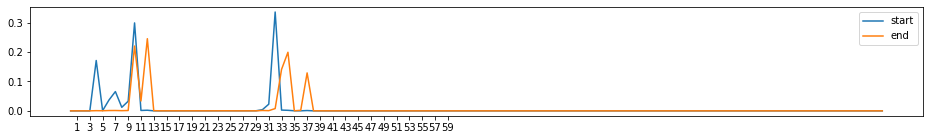

In [17]:
plot_pred(766)

Origin sentence :  Just spent the last two hours playing L4D with babe  Had HELLA fun. I love him <3
Pred start_word :  I 
Pred end_word :  fun.
Target start_word :  fun.
Target end_word :  fun.


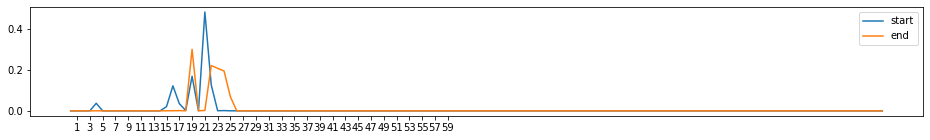

In [18]:
plot_pred(1123)

Origin sentence :  Just got back from  `s party! Sooo much fun! Boom boom pow~ hahaha! ooh and I just told my mom happy mother`s day
Pred start_word :  happy 
Pred end_word :  fun!
Target start_word :  fun!
Target end_word :  fun!


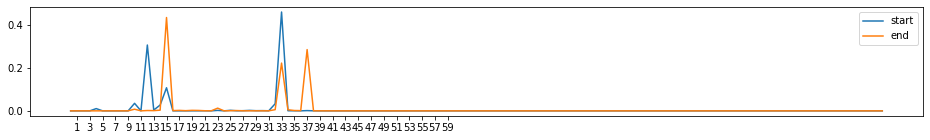

In [19]:
plot_pred(2074)

Origin sentence :  :: holy kraut. I canNOT stay up this late. But the book is done and in the author`s in box.  Tucking in with kitty-boys now. Nighty-night.
Pred start_word :  I 
Pred end_word :  t.
Target start_word :  canNOT
Target end_word :  canNOT


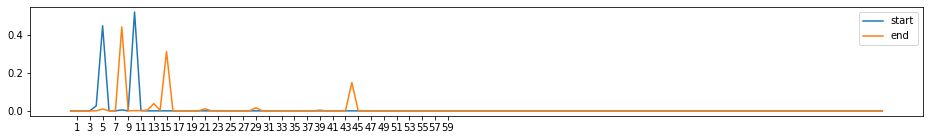

In [20]:
plot_pred(7858)

#  Start_idx > End_idx

In [21]:
print("Start_idx > End_idx")
print("count : ",len(df[df['start_idx'] > df['end_idx']]))
print("mean : " , sum(df[df['start_idx'] > df['end_idx']]['jaccard']) / len(df[df['start_idx'] > df['end_idx']]))

Start_idx > End_idx
count :  55
mean :  0.40618661773009607


In [22]:
df[df['start_idx'] > df['end_idx']]['sentiment'].value_counts()

neutral     20
negative    18
positive    17
Name: sentiment, dtype: int64

In [23]:
df[df['start_idx'] > df['end_idx']][['text', 'selected_text', 'sentiment', 'pred', 'jaccard', 'start_idx', 'end_idx']]

,text,selected_text,sentiment,pred,jaccard,start_idx,end_idx
216,which means you`re just going to have to come...,which means you`re just going to have to come ...,neutral,which means you`re just going to have to come ...,1.000000,25,23
406,"yep infact she is popular, miss india 99, tal...","she is popular,",positive,talented,0.000000,17,10
766,Jon made one of the greatest dinners ever: roa...,one of the greatest dinners ever:,positive,y,0.000000,32,12
1123,Just spent the last two hours playing L4D with...,fun.,positive,i,0.000000,21,19
1895,She! Maybe that was our first mistake. Not e...,mistake.,negative,not,0.000000,13,11
2074,Just got back from `s party! Sooo much fun! B...,fun!,positive,happy,0.000000,33,15
2524,Learned a lesson the hard way. Lost my USB sti...,Learned a lesson the hard way.,negative,lost,0.000000,11,9
2676,cont...and then it goes to waste no one like...,cont...and then it goes to waste no one likes...,neutral,cont...and then it goes to waste no one likes ...,1.000000,23,11
3150,I always get really excited when `Steal My Kis...,excited,positive,...,0.000000,25,8
3371,Nice! What r ur plans for 2day? Oh n Happy Mo...,Nice!,positive,happy,0.000000,16,4


# short tex length

In [25]:
WORD_LEN = 6
df.loc[df.text_len < WORD_LEN, 'selected_rate']

2        0.400000
3        0.600000
7        1.000000
8        1.000000
15       1.000000
           ...   
27433    1.000000
27452    1.000000
27456    1.000000
27458    0.200000
27474    0.333333
Name: selected_rate, Length: 4323, dtype: float64